<a href="https://colab.research.google.com/github/hannape/CNN-second/blob/master/multitaper_spectro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')
from __future__ import print_function


In [0]:
!pip install audiosegment
!pip install librosa
!pip install pydub
!pip install webrtcvad
!pip install librosa
!pip install -q spectrum
!pip install pkgconfig libtfr

import libtfr
import librosa
from scipy.io import wavfile
from random import choice
import librosa
from pydub import AudioSegment
from pydub.utils import make_chunks
import math
import audiosegment
from pydub import AudioSegment
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import glob
import os
import scipy
import librosa
from librosa import display
from librosa.core import power_to_db
from librosa.core import amplitude_to_db
import IPython.display as ipd

Pierwszy etap: wyciągnać nr chunksów  z danego nagrania, które byłybrane jako random


In [12]:
import os
import numpy as np
source_npz = "drive/My Drive/repr7_2016/"
source_audio = "drive/My Drive/nagrania/2017/"

nazwa_list=[]
a = os.listdir(source_npz)
for i in range(0,np.shape(a)[0]):
  nazwa_list.append(os.path.splitext(a[i])[0])
  
print(nazwa_list)

['9niski_szum_BUK4_20161025_000604_7rep', '6wichura_deszcz_BUK4_20161005_022304_7rep', '1swierszcze_nakladki_BUK4_20160925_204604_7rep', '4szum_sredni_BUK4_20160918_013604_7rep', '7wiatr_BUK4_20161006_002104_7rep', '3wzgledna_cisza_BUK4_20160925_224604_7rep', '5szum_sredni_nakladki_BUK4_20161011_000804_7rep', '8deszczk_bezptasio_BUK4_20161015_235704_7rep', '2koniec_swierszczy_BUK4_20160925_221604_7rep', 'BUK4_20161022_224004_7rep', 'BUK4_20161019_011904_7rep', 'BUK4_20161104_011504_7rep', 'BUK4_20161103_204504_7rep', 'BUK4_20161024_223604_7rep', 'BUK4_20161104_004504_7rep', 'BUK4_20161103_181504_7rep', 'BUK4_20161031_232104a_7rep', 'BUK4_20161031_232104b_7rep', 'BUK4_20161103_234504_7rep', 'BUK4_20161104_034504_7rep', 'BUK4_20161104_051504_7rep', 'BUK4_20161104_031504_7rep', 'BUK4_20161104_014504_7rep', 'BUK4_20161104_041504_7rep', 'BUK4_20161104_044504_7rep', 'BUK4_20161104_024504_7rep', 'BUK4_20161104_054506_7rep', 'BUK4_20161104_021504_7rep', 'BUK4_20161104_011504b1110_1230_7rep', '

In [13]:
dane1 = np.load(source + nazwa_list[0] + '.npz' )
print('Dostepne dane: ' + str(dane1.files))
chunks_nobirds = dane1["nobirds_chunks"]
print(chunks_nobirds)

Dostepne dane: ['rep1', 'rep2', 'rep3', 'rep4', 'rep5', 'rep6', 'rep7', 'final_description', 'labels', 'nobirds_chunks', 'spec']
[ 849 4639 3600 3450 2932 2574 3017 1328  742 3966 4137 2665 1879 1369
 4355 3835 4622 3424  445 4390 1149  460  662  727 3712 3627 1294 4150
 4748 4618 4490 2661  143 3847 1734 5038 3436 4852 2118 1247 4708 2306
  998  999 4568  186 2058 3530 4066 4044]


Sprawdźmy jakies multitaperki

In [104]:
source_audio = "drive/My Drive/nagrania/2017/"
source_labels = "drive/My Drive/labele/2017/"
nagrania_list=[]
a = sorted(os.listdir(source_labels))
for i in range(0,np.shape(a)[0]):
  nagrania_list.append(os.path.splitext(a[i])[0])
  #print("nagranie nr "+ str(i) + ": " + str(nagrania_list[i]))
print(nagrania_list)


['BUK4_20171001_020404a', 'BUK4_20171017_015504b', 'BUK4_20171022_004304a', 'BUK5_20170902_234404', 'BUK5_20170904_233905', 'BUK5_20170906_023604', 'BUK5_20170910_025605', 'BUK5_20170912_015105', 'BUK5_20170920_013105a', 'BUK5_20170920_013105b', 'BUK5_20170923_025405', 'BUK5_20171007_024907b', 'BUK5_20171007_031905', 'BUK5_20171026_010405', 'BUK5_20171102_045004b']


In [105]:
name = nagrania_list[1]
print(name)
chunk_length_ms = 500
chunk_overlap = 150
fs=44100
minimal_duration = 4   # minimalny czas trwania głosu w ms, b zakwalifikowac chunka jako hasbird
f_min = 4000           # minimalna częstotliwość analizowana ze spektro
f_max = 9500           # maksymalna częstotliwość analizowana ze spektro

name_txt = name + ".txt"

with open((source_labels + name_txt), 'r+') as f:  # zmiana na kropki
      text = f.read()
      f.seek(0)
      f.truncate()
      f.write(text.replace(',', '.'))
      
########## Odczyt labeli z csv, wyczyszczenie zaznaczonych trzasków (t, ?)

y_read = pd.read_csv(source_labels + name_txt,  header=None, sep = "\t")
y_read.columns = ["start", "end", "bird"]
y_read_cleanedA = y_read[y_read['bird']!= 't']  # deleted 't'
y_read_cleaned = y_read_cleanedA[y_read_cleanedA['bird']!= 't?'] # deleted 't?'
print(y_read_cleaned)
y_read = y_read_cleaned      

########## Wyszukanie pozytywnych fragmentów - fragmentów zawierający głos, ilość takich ramek

hasbird_frame = []
species=[]
sum_birds=0
has_bird = 1
plot_repr = 0          # czy wyrysowywać głosy wszystkie
play_sound = 1

for i in range(0,math.floor(nr_of_chunks)): #(2300,2600): #math.floor(nr_of_chunks)): 
  frame_start = i*(chunk_length_ms - chunk_overlap)
  frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
  frame = myaudio[frame_start : frame_end]
  x = range(frame_start,frame_end)

  for j in y_read.index.tolist():
    bird_start = int(round(y_read.start[j]*1000))
    bird_end = int(round(y_read.end[j]*1000))
    y = range(bird_start,bird_end)

    intersect_start = max(x[0], y[0])
    intersect_end = min(x[-1], y[-1])+1
    range1 = (range(intersect_start, intersect_end))

    if len(range1)> minimal_duration: 
      sum_birds = sum_birds+1

      species.append(y_read.bird[j])
      hasbird_frame.append(i)#([i, frame_start, frame_end, intersect_start, intersect_end, bird_start, bird_end, has_bird, 0, 0])

print(np.shape(hasbird_frame))


BUK4_20171017_015504b
          start          end bird
0     14.397228    14.407423    s
1     33.466116    33.483896    s
2     45.658888    45.788550    s
3     79.546081    79.704161    k
4     79.940537    80.093582    k
5     96.641515    96.669666    s
6    336.329183   336.584699    d
7    345.023484   345.047104    s
8    347.784107   347.940879    k
9    371.491063   371.723057    d
10   382.698240   382.877713    d
11   410.197607   410.217218    s
12   508.556210   508.612009   ni
13   737.471900   737.507845    s
14   747.220718   747.228805    s
15   861.782082   861.804653    s
16   881.223984   881.275248    s
17   895.894470   895.912220    s
18   898.406547   898.560386    k
19   993.764976   994.030359    k
20  1028.006904  1028.020398    s
21  1031.472774  1031.520151    s
22  1032.998147  1033.021835    s
23  1037.943090  1038.017755    s
24  1046.219506  1046.280330    s
25  1226.054522  1226.314182    k
26  1279.860001  1279.868921    s
27  1294.111438  1294.1303

AttributeError: ignored

In [106]:
y = list(set(hasbird_frame)) # dropping duplicates from array
print(np.shape(y))
print(np.shape(hasbird_frame))
print(hasbird_frame_no_dup )
print(hasbird_frame)

(72,)
(76,)
[40, 41, 95, 130, 226, 227, 228, 275, 276, 960, 961, 985, 993, 994, 1060, 1061, 1062, 1093, 1171, 1172, 1452, 1453, 2106, 2107, 2134, 2461, 2462, 2517, 2559, 2566, 2567, 2838, 2839, 2840, 2936, 2937, 2946, 2947, 2951, 2965, 2988, 2989, 3502, 3503, 3656, 3697, 3710, 3711, 3724, 3725, 3990, 4034, 4035, 4039, 4040, 4041, 4059, 4060, 4225, 4226, 4227, 4228, 4418, 4419, 4703, 4704, 4809, 4810, 4863, 4864, 5034, 5035]
[40, 41, 95, 130, 226, 227, 227, 228, 275, 276, 960, 961, 985, 993, 994, 1060, 1061, 1062, 1093, 1171, 1172, 1452, 1453, 2106, 2107, 2134, 2461, 2462, 2517, 2559, 2566, 2567, 2838, 2839, 2840, 2936, 2937, 2946, 2947, 2951, 2965, 2988, 2989, 3502, 3503, 3656, 3697, 3710, 3711, 3724, 3725, 3990, 4034, 4035, 4039, 4040, 4040, 4041, 4059, 4060, 4225, 4226, 4226, 4227, 4227, 4228, 4418, 4419, 4703, 4704, 4809, 4810, 4863, 4864, 5034, 5035]


[40, 41, 95, 130, 226, 227, 228, 275, 276, 960, 961, 985, 993, 994, 1060, 1061, 1062, 1093, 1171, 1172, 1452, 1453, 2106, 2107, 2134, 2461, 2462, 2517, 2559, 2566, 2567, 2838, 2839, 2840, 2936, 2937, 2946, 2947, 2951, 2965, 2988, 2989, 3502, 3503, 3656, 3697, 3710, 3711, 3724, 3725, 3990, 4034, 4035, 4039, 4040, 4041, 4059, 4060, 4225, 4226, 4227, 4228, 4418, 4419, 4703, 4704, 4809, 4810, 4863, 4864, 5034, 5035]
[40, 41, 95, 130, 226, 227, 227, 228, 275, 276, 960, 961, 985, 993, 994, 1060, 1061, 1062, 1093, 1171, 1172, 1452, 1453, 2106, 2107, 2134, 2461, 2462, 2517, 2559, 2566, 2567, 2838, 2839, 2840, 2936, 2937, 2946, 2947, 2951, 2965, 2988, 2989, 3502, 3503, 3656, 3697, 3710, 3711, 3724, 3725, 3990, 4034, 4035, 4039, 4040, 4040, 4041, 4059, 4060, 4225, 4226, 4226, 4227, 4227, 4228, 4418, 4419, 4703, 4704, 4809, 4810, 4863, 4864, 5034, 5035]
--- chunk nr 40 recording BUK4_20171017_015504b run 1---  
[[2.53231540e-06 2.12170491e-06 3.37185391e-07 ... 2.16292293e-06
  1.72132862e-06 7.4

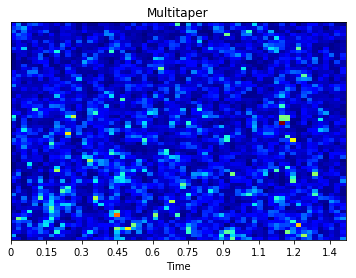

--- chunk nr 41 recording BUK4_20171017_015504b run 2---  
[[4.33614029e-06 1.16780622e-06 2.69256737e-06 ... 1.99426058e-06
  3.81956567e-06 2.43205940e-06]
 [4.00269871e-07 2.26390004e-06 6.75544013e-07 ... 2.83243049e-06
  4.73253539e-07 1.26682082e-06]
 [1.16333174e-06 8.09428940e-07 4.66850027e-07 ... 2.71604679e-06
  6.16886631e-07 2.70451086e-06]
 ...
 [4.92722533e-06 6.08561809e-07 1.94300405e-06 ... 2.35311455e-06
  1.47233771e-06 1.30051997e-06]
 [3.99289287e-06 6.21637411e-06 7.16494625e-06 ... 4.89673768e-07
  8.00940040e-07 1.38293826e-06]
 [4.34365812e-06 4.64798910e-06 2.63100325e-06 ... 6.98942699e-07
  6.00793113e-07 8.50061965e-07]]


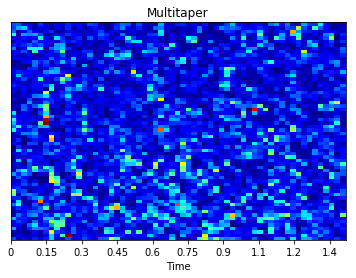

--- chunk nr 95 recording BUK4_20171017_015504b run 3---  
[[4.78368559e-07 3.07279566e-06 2.79800502e-06 ... 1.65845825e-05
  1.25909766e-06 6.71539435e-06]
 [8.21572504e-07 3.74149184e-06 9.15364875e-06 ... 1.88449900e-06
  1.57367549e-06 2.98652988e-06]
 [7.51619141e-06 2.05487347e-06 8.69303288e-06 ... 2.08757644e-06
  3.04367744e-06 2.70566781e-06]
 ...
 [3.79433121e-06 4.04039092e-06 7.36740257e-07 ... 3.09148328e-06
  1.30568678e-06 4.42687302e-07]
 [5.78686541e-06 6.16145740e-06 5.89673541e-06 ... 8.15472727e-06
  2.49444280e-06 1.20616832e-06]
 [0.00000000e+00 6.12930955e-06 1.59372782e-06 ... 1.65213260e-06
  4.81828846e-06 2.96013454e-06]]


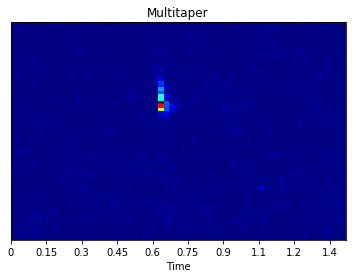

--- chunk nr 130 recording BUK4_20171017_015504b run 4---  
[[4.53472986e-06 5.71339833e-06 8.26284935e-07 ... 1.63406815e-06
  4.17817544e-06 2.22702322e-06]
 [1.87537218e-06 1.78876332e-06 1.42724860e-06 ... 1.99819282e-06
  5.46872750e-06 4.56957766e-06]
 [3.42900869e-06 3.01525868e-06 6.31489094e-06 ... 3.57335250e-06
  3.35223612e-06 3.56340477e-06]
 ...
 [7.74798516e-07 1.43081665e-06 1.79345552e-06 ... 6.20631077e-07
  7.76152764e-06 4.03073349e-06]
 [2.90169872e-06 1.49747407e-06 2.30686407e-06 ... 9.13838768e-07
  6.64352555e-06 2.49548358e-06]
 [3.65430418e-06 4.41555401e-06 1.19503469e-06 ... 7.48154918e-07
  1.70660645e-06 6.64038261e-06]]


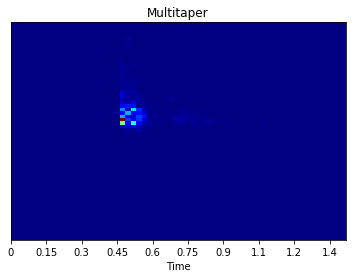

--- chunk nr 226 recording BUK4_20171017_015504b run 5---  
[[3.19970301e-07 2.80604855e-06 2.22730123e-06 ... 3.58962451e-06
  1.04764992e-06 8.04449967e-06]
 [2.70143418e-06 1.20251274e-06 4.44642909e-06 ... 4.57370052e-06
  9.32104350e-07 6.68682299e-06]
 [1.19616672e-05 4.49102019e-06 2.76802898e-06 ... 3.32496655e-06
  1.98311962e-06 4.13584075e-06]
 ...
 [2.65358688e-06 2.34141678e-06 3.16620136e-06 ... 1.04322605e-06
  7.15693623e-07 6.42978938e-07]
 [2.85645654e-06 3.47357204e-06 3.20768919e-06 ... 2.96958977e-06
  2.65432706e-06 7.21282258e-07]
 [4.44838499e-06 1.94112221e-06 5.59134267e-07 ... 1.66236002e-06
  1.81656153e-06 5.53500669e-07]]


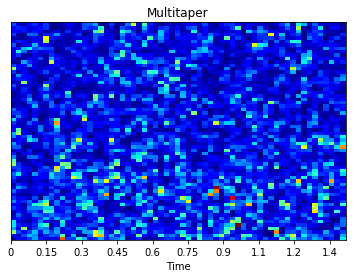

--- chunk nr 227 recording BUK4_20171017_015504b run 6---  
[[4.13914305e-06 2.82900699e-06 3.77247821e-06 ... 6.70565280e-06
  2.01480251e-06 1.55892276e-06]
 [1.92082004e-06 3.89942403e-06 2.38612569e-07 ... 1.12557564e-06
  3.32278196e-06 1.16526736e-06]
 [5.49393875e-07 2.76995451e-06 1.42782120e-06 ... 5.43639575e-07
  3.34112975e-06 2.08261985e-06]
 ...
 [8.22802177e-06 2.61619747e-06 9.15962914e-06 ... 2.80253270e-06
  3.20899030e-06 2.10243105e-06]
 [2.11528905e-06 2.87450166e-06 1.49963650e-06 ... 1.85419877e-06
  3.56971146e-06 1.32440502e-06]
 [2.39886266e-06 1.10511146e-06 1.26817580e-06 ... 3.34965580e-06
  3.97993924e-06 1.92089071e-06]]


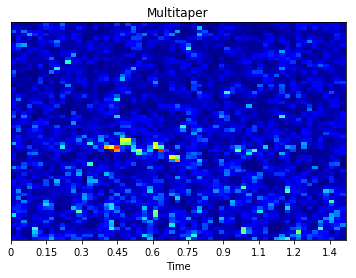

--- chunk nr 228 recording BUK4_20171017_015504b run 7---  
[[5.35564133e-06 9.64427451e-06 7.27646886e-06 ... 5.86869261e-06
  1.34034936e-06 5.31658383e-06]
 [1.18302124e-06 7.30090320e-06 4.92805337e-06 ... 3.76303935e-06
  1.36184249e-05 8.22119822e-06]
 [4.07135001e-06 3.77890808e-06 6.97116277e-06 ... 5.86586084e-06
  1.10880952e-05 4.91101033e-06]
 ...
 [1.98460729e-07 3.57043727e-07 1.32133474e-06 ... 3.26829343e-06
  2.69807592e-06 2.79183759e-06]
 [4.84171034e-07 3.41270163e-07 2.70477788e-06 ... 5.06886540e-06
  8.65322961e-07 2.38647473e-06]
 [1.25858077e-06 1.26942324e-06 7.35325231e-07 ... 3.04744050e-06
  1.05156389e-06 2.13676978e-06]]


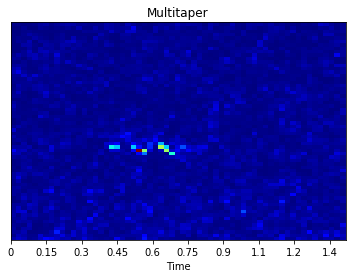

--- chunk nr 275 recording BUK4_20171017_015504b run 8---  
[[1.03744052e-05 1.33135040e-06 4.67411208e-06 ... 5.12674752e-06
  1.23664063e-05 8.00084338e-07]
 [2.77658169e-06 7.08618435e-06 4.63569099e-06 ... 2.71703695e-06
  2.92746768e-06 4.21220769e-06]
 [1.49688045e-06 8.57759118e-06 1.44972098e-06 ... 1.61573678e-06
  4.25791736e-06 7.72571050e-06]
 ...
 [1.74557317e-06 4.10702555e-06 9.56475905e-07 ... 4.54761827e-06
  1.95403133e-06 2.42274602e-07]
 [1.21752083e-06 1.33594621e-06 9.22496588e-07 ... 2.11068015e-06
  1.03168098e-06 1.20964382e-06]
 [1.60654852e-06 3.06997060e-06 8.68736570e-06 ... 7.61446224e-07
  4.22202640e-06 2.71264951e-06]]


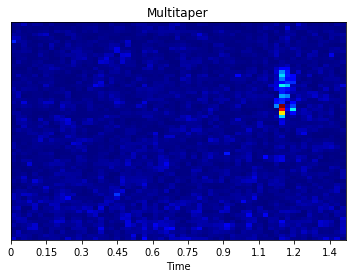

--- chunk nr 276 recording BUK4_20171017_015504b run 9---  
[[6.13632563e-06 1.53576688e-06 2.80390617e-06 ... 1.96775764e-06
  1.31354609e-06 1.90781804e-06]
 [6.09745687e-06 1.15897800e-06 5.87110869e-06 ... 5.70310630e-07
  1.38259056e-05 9.25948115e-07]
 [2.86648829e-06 3.91230634e-06 2.18251761e-07 ... 5.97217041e-06
  2.03030528e-05 1.05597700e-06]
 ...
 [7.64428612e-07 1.33929793e-06 2.21671610e-06 ... 2.65071414e-06
  8.34594083e-07 4.17012484e-06]
 [1.18974178e-06 4.28428862e-07 5.51155177e-06 ... 4.43078447e-06
  1.27407044e-06 6.38954888e-06]
 [3.03721424e-06 0.00000000e+00 3.13081919e-06 ... 1.53420045e-06
  7.10667604e-06 2.55394978e-06]]


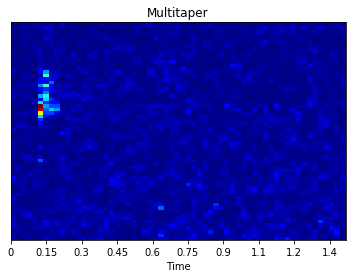

--- chunk nr 960 recording BUK4_20171017_015504b run 10---  
[[6.89177941e-06 5.85165843e-06 1.33180451e-06 ... 1.53444196e-06
  9.65630158e-07 7.96324611e-06]
 [7.64126247e-06 6.00505549e-06 9.20018942e-06 ... 7.59340150e-06
  1.50539019e-06 3.66195706e-06]
 [2.07015049e-06 7.87042813e-06 2.64915474e-06 ... 1.04680150e-05
  3.62155365e-06 3.36769496e-06]
 ...
 [2.78654007e-06 1.31837917e-07 1.45159876e-05 ... 9.72671311e-06
  2.43790470e-06 2.01059915e-06]
 [1.08094940e-06 0.00000000e+00 5.72595238e-06 ... 2.01603478e-06
  4.92495626e-06 7.62585009e-06]
 [1.02085191e-06 1.53454381e-06 1.06231693e-06 ... 1.66610145e-06
  4.13832430e-06 7.84796167e-07]]


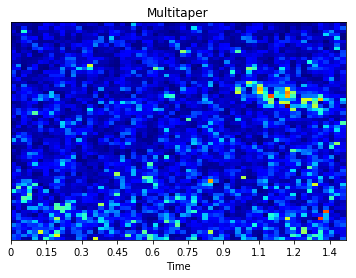

--- chunk nr 961 recording BUK4_20171017_015504b run 11---  
[[8.38278868e-06 2.30025315e-06 6.24745518e-06 ... 2.75539691e-06
  2.77804277e-06 2.78497650e-06]
 [1.75385592e-06 1.80277065e-06 2.19584599e-06 ... 3.70521473e-06
  1.59186515e-06 3.46911922e-06]
 [1.81804294e-06 3.70883793e-07 2.58216100e-06 ... 4.36796183e-06
  1.53492439e-06 4.68869122e-06]
 ...
 [4.75004881e-06 2.35165338e-06 5.87292604e-07 ... 1.68184343e-06
  2.41606985e-06 2.46668485e-06]
 [1.78505723e-06 4.46471322e-06 2.99939437e-06 ... 1.03979513e-06
  5.30762745e-06 3.59347427e-06]
 [2.69072349e-06 3.72779417e-06 2.29311820e-06 ... 3.66163999e-06
  4.16518781e-06 2.41897157e-06]]


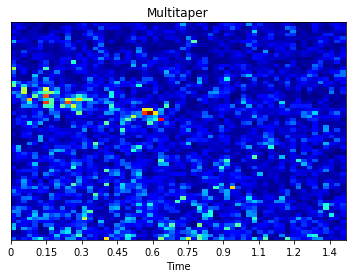

--- chunk nr 985 recording BUK4_20171017_015504b run 12---  
[[7.41884564e-06 9.35589978e-06 5.78479996e-06 ... 1.76795705e-06
  1.00191873e-05 1.26042369e-06]
 [7.01577929e-06 3.36683119e-06 6.99866951e-06 ... 2.28496232e-06
  5.27519654e-06 6.09422159e-06]
 [9.47942080e-06 1.46568683e-06 5.23152299e-06 ... 2.08632245e-06
  6.73055391e-06 1.42012220e-05]
 ...
 [3.07061263e-06 5.40408056e-07 2.91679844e-06 ... 4.01665128e-07
  2.56434596e-06 4.80063733e-06]
 [2.50422303e-06 2.40109153e-07 5.29576058e-06 ... 3.90858182e-06
  6.73461188e-06 3.53934088e-06]
 [1.39722875e-06 4.07214430e-07 4.12370728e-06 ... 1.51125702e-05
  1.29390468e-05 2.46098942e-06]]


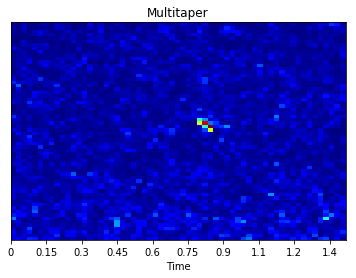

--- chunk nr 993 recording BUK4_20171017_015504b run 13---  
[[2.88410483e-06 1.71441332e-06 4.87078209e-06 ... 6.50394373e-07
  3.64615727e-07 5.34044603e-06]
 [1.07687193e-05 8.72694507e-06 1.51589491e-05 ... 6.61936169e-07
  1.75504537e-06 2.51640131e-06]
 [3.69987070e-06 3.87271700e-06 4.44488305e-06 ... 6.25355598e-07
  1.07080281e-06 4.54253364e-06]
 ...
 [1.85289836e-06 1.12628378e-06 1.44869626e-06 ... 7.38373568e-08
  9.19876135e-07 1.64494282e-06]
 [1.32961963e-06 1.03963719e-06 1.35568651e-06 ... 4.06706746e-07
  1.74787178e-06 4.48316096e-06]
 [5.03138826e-07 7.58436266e-07 1.25418257e-06 ... 4.20279594e-07
  7.41790673e-07 6.04544499e-07]]


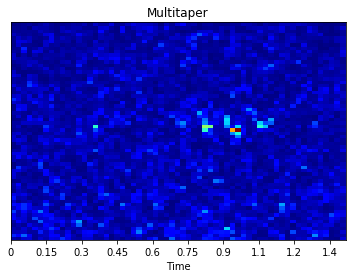

--- chunk nr 994 recording BUK4_20171017_015504b run 14---  
[[9.53143083e-07 1.81976032e-06 2.14868023e-06 ... 6.29345257e-06
  5.59096544e-06 9.48037810e-06]
 [2.02083838e-06 2.22188899e-06 5.26169906e-07 ... 1.27180724e-06
  4.21866759e-06 3.58728692e-06]
 [6.25708580e-06 1.69076522e-06 1.48021556e-06 ... 2.58530381e-06
  2.30607003e-06 3.02190465e-06]
 ...
 [1.52616948e-06 1.73993414e-06 7.04273797e-06 ... 3.40045210e-06
  4.34930027e-06 1.32366362e-06]
 [2.64848075e-06 1.31845038e-06 4.80227409e-06 ... 1.50325505e-06
  4.50545091e-06 6.13041303e-06]
 [4.46885828e-06 1.24172788e-06 8.98715554e-07 ... 2.23444003e-07
  1.34802448e-06 4.91954259e-06]]


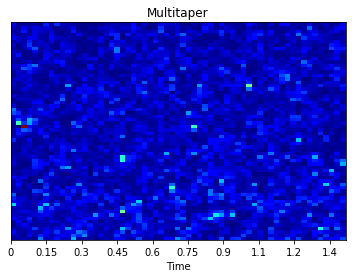

--- chunk nr 1060 recording BUK4_20171017_015504b run 15---  
[[1.38617769e-06 1.33066418e-05 3.17927410e-07 ... 3.28542993e-06
  5.18723950e-08 1.35668104e-07]
 [1.05324785e-05 3.30959592e-06 8.30602459e-07 ... 2.67203392e-06
  7.88106703e-07 2.95479278e-07]
 [5.10291355e-06 7.27357332e-07 4.89459346e-06 ... 5.35056016e-06
  7.74224634e-06 4.21468838e-06]
 ...
 [3.28247358e-06 7.97965334e-07 1.79420573e-06 ... 5.03211401e-06
  3.93900687e-06 1.12648264e-06]
 [8.52150610e-07 2.53124101e-06 1.32220984e-06 ... 2.16114845e-06
  2.27073581e-06 2.00830810e-06]
 [2.83695940e-06 3.70839817e-06 1.03953846e-06 ... 6.56056647e-07
  2.27211965e-06 5.14299144e-06]]


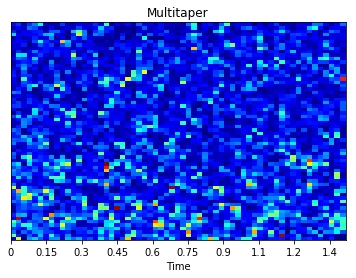

--- chunk nr 1061 recording BUK4_20171017_015504b run 16---  
[[6.79492255e-06 4.04683253e-06 1.95712319e-07 ... 3.06389029e-07
  1.34977351e-06 5.29749638e-06]
 [8.56124310e-06 9.77210303e-07 2.49006665e-06 ... 2.27531182e-08
  2.16105324e-06 4.22605605e-06]
 [6.71398051e-06 1.32336212e-05 3.45207465e-06 ... 9.82244062e-07
  2.25148588e-06 1.30572456e-06]
 ...
 [4.81302560e-07 1.34137124e-06 2.03493014e-06 ... 6.62027150e-06
  6.59133474e-07 4.15495962e-06]
 [5.03065370e-06 3.32414654e-06 8.38555735e-07 ... 3.31925022e-06
  2.14404757e-06 3.49716918e-06]
 [2.00276620e-06 1.10701856e-06 1.16032478e-06 ... 4.38883126e-06
  1.68845312e-06 1.55344114e-06]]


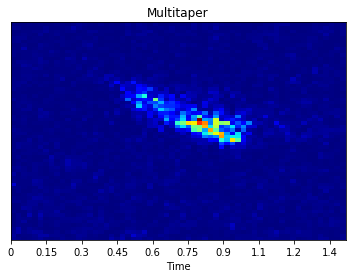

--- chunk nr 1062 recording BUK4_20171017_015504b run 17---  
[[4.52464067e-06 8.40709488e-06 7.62857099e-06 ... 6.11972777e-06
  3.26300655e-06 3.14593302e-06]
 [1.00301195e-06 4.28237604e-06 4.43706668e-06 ... 1.13885912e-06
  4.22330719e-06 2.32312840e-06]
 [1.69983157e-06 5.26808004e-06 1.89969379e-06 ... 2.01346582e-06
  3.27093638e-06 2.49202879e-06]
 ...
 [1.47493445e-06 3.03005169e-06 1.97534415e-06 ... 1.45878879e-06
  4.11434576e-07 4.91484446e-07]
 [1.42686478e-06 2.41404648e-06 2.57033586e-06 ... 1.71849698e-06
  1.01375773e-06 1.19974413e-06]
 [7.15079699e-07 1.23419844e-06 2.92210467e-06 ... 9.48949548e-07
  2.40365718e-06 3.01394493e-06]]


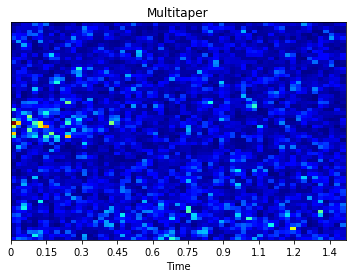

--- chunk nr 1093 recording BUK4_20171017_015504b run 18---  
[[2.46717885e-06 3.03055258e-06 8.99600677e-06 ... 1.16804728e-06
  1.58646196e-06 4.29311646e-06]
 [2.48837192e-06 5.63676996e-06 1.90396656e-06 ... 3.40926649e-07
  3.91663640e-06 3.67407596e-06]
 [4.59803865e-06 8.71653813e-06 5.18263452e-06 ... 9.79011227e-07
  2.08202977e-06 2.71217033e-06]
 ...
 [7.92485478e-06 2.67022464e-06 2.96014771e-07 ... 6.27833815e-06
  4.25503510e-06 4.67437701e-06]
 [7.50393204e-07 4.51010756e-06 3.26191518e-06 ... 8.46037007e-06
  5.80076971e-06 4.44757955e-06]
 [2.30631604e-06 2.15826314e-06 3.99929790e-06 ... 5.15667371e-06
  8.26469713e-06 4.37683984e-06]]


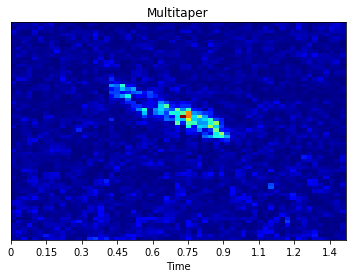

--- chunk nr 1171 recording BUK4_20171017_015504b run 19---  
[[1.02037285e-06 3.72890412e-06 3.05411911e-06 ... 8.63239654e-07
  2.54943973e-06 3.14588139e-06]
 [2.26842739e-06 4.01612964e-06 8.16115030e-07 ... 1.11167228e-06
  8.91654457e-06 9.96056170e-07]
 [2.33948023e-06 2.60957376e-06 5.84878345e-06 ... 5.07552157e-06
  7.15021842e-06 1.02798563e-06]
 ...
 [6.48233092e-06 1.73808523e-06 2.10221006e-06 ... 2.14902969e-06
  5.90034477e-06 5.47157314e-06]
 [3.32521895e-06 2.24958086e-06 7.81097739e-06 ... 4.10177099e-06
  8.25368191e-06 3.50983191e-06]
 [2.15912516e-06 4.32636529e-06 3.26245254e-06 ... 1.47086026e-06
  3.29923456e-06 9.68184486e-06]]


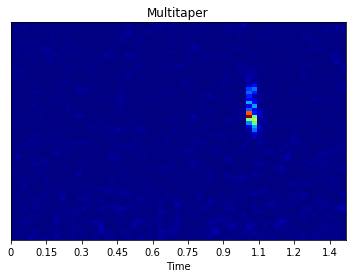

--- chunk nr 1172 recording BUK4_20171017_015504b run 20---  
[[3.50022732e-06 3.84544362e-06 2.12692498e-06 ... 3.52404446e-06
  2.92591582e-06 5.45202837e-06]
 [3.89776726e-06 7.12624890e-06 6.34986103e-06 ... 2.45317595e-06
  2.54953917e-06 5.94797587e-06]
 [6.59353889e-06 1.36950986e-06 2.36790013e-06 ... 5.24223671e-07
  1.42678087e-06 3.41993995e-06]
 ...
 [2.92403554e-06 2.27724534e-06 2.36216513e-06 ... 2.60435637e-06
  4.39610384e-07 4.01441844e-06]
 [1.15409118e-06 1.92281313e-06 6.81130185e-07 ... 6.03902963e-06
  1.18298486e-06 1.34142594e-06]
 [9.54133062e-07 8.34220353e-07 4.39525916e-07 ... 6.52406532e-06
  1.00430345e-06 9.08699247e-07]]


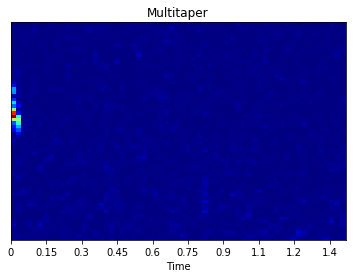

--- chunk nr 1452 recording BUK4_20171017_015504b run 21---  
[[2.00752236e-05 3.05838177e-05 1.30567912e-05 ... 2.93470946e-06
  3.03522502e-06 1.64657404e-06]
 [4.54349591e-06 9.10004084e-06 8.62534158e-06 ... 1.43595751e-06
  5.11682510e-06 1.89675974e-06]
 [2.11932126e-06 7.18884716e-07 1.59517622e-05 ... 5.51001034e-06
  1.09017481e-05 4.04354325e-06]
 ...
 [4.66090828e-06 7.17815109e-06 2.62139477e-06 ... 6.13729316e-06
  1.20911438e-06 4.39633368e-07]
 [1.53106020e-06 9.29286267e-07 2.20740903e-06 ... 2.44999787e-06
  4.74664388e-06 9.19975282e-08]
 [9.23932601e-07 1.36648581e-06 1.41213455e-06 ... 4.95787932e-06
  8.41841995e-06 1.37057856e-07]]


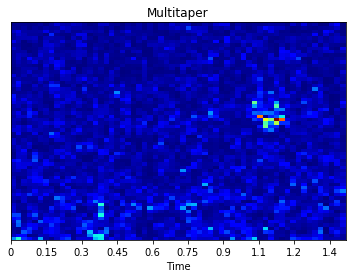

--- chunk nr 1453 recording BUK4_20171017_015504b run 22---  
[[1.81549391e-05 9.98484239e-06 3.09375720e-06 ... 1.21085167e-05
  1.26383933e-05 9.48398378e-06]
 [1.27689398e-05 7.25537105e-06 1.87639685e-06 ... 4.40507647e-06
  4.36925452e-06 5.55607541e-06]
 [5.49813677e-06 1.55918955e-06 6.72535050e-06 ... 3.80054263e-06
  4.09040007e-06 4.37119906e-06]
 ...
 [1.17616425e-06 7.23046064e-07 5.08011799e-06 ... 3.99126667e-06
  4.72298084e-07 6.17738519e-06]
 [6.05959838e-07 1.74964914e-06 6.21083157e-06 ... 2.02985720e-06
  7.83343010e-07 1.32426093e-06]
 [1.17270913e-06 1.47627807e-06 2.88923400e-06 ... 7.35063035e-06
  8.40255660e-06 2.69029441e-07]]


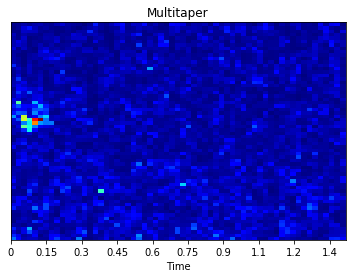

--- chunk nr 2106 recording BUK4_20171017_015504b run 23---  
[[9.09089802e-06 1.16787682e-05 0.00000000e+00 ... 3.63606760e-06
  1.37257167e-06 3.74332520e-06]
 [6.51922018e-06 5.09447676e-06 4.62369557e-06 ... 3.30710863e-06
  1.33990746e-06 3.54270943e-06]
 [3.61049954e-06 6.43113563e-06 3.58676418e-06 ... 3.61329313e-06
  9.35648004e-07 2.38769496e-06]
 ...
 [3.06188889e-06 1.60326564e-06 1.88050142e-06 ... 1.52084654e-06
  4.13921426e-07 6.01096025e-07]
 [5.45776711e-06 1.97781562e-06 1.88245897e-06 ... 5.70626800e-06
  1.59149037e-06 1.16211382e-06]
 [2.13080713e-06 1.26387251e-06 4.52080616e-06 ... 2.23877161e-06
  1.55229703e-06 2.75757760e-06]]


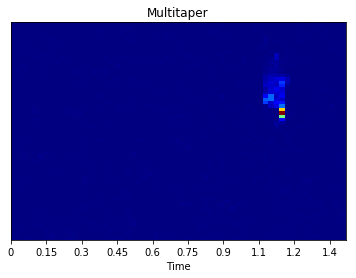

--- chunk nr 2107 recording BUK4_20171017_015504b run 24---  
[[4.20897508e-06 8.48810468e-07 1.41096423e-06 ... 1.42962352e-06
  1.45246987e-06 3.97360535e-06]
 [2.25961786e-06 9.08312925e-07 2.39877750e-06 ... 7.99955420e-06
  5.00307557e-06 5.34594060e-06]
 [1.46660027e-06 1.40838545e-06 1.99742785e-06 ... 2.43516130e-06
  5.98043907e-06 3.02939256e-06]
 ...
 [1.04343870e-05 7.47724919e-07 2.48689240e-06 ... 7.08768646e-06
  5.53766587e-06 7.81784381e-06]
 [4.73268651e-06 3.57949111e-06 2.69293048e-06 ... 3.69326952e-06
  2.77026611e-06 3.72749516e-06]
 [7.83826906e-07 5.29988199e-06 1.83980494e-06 ... 1.24957211e-06
  8.65811958e-07 6.29544511e-07]]


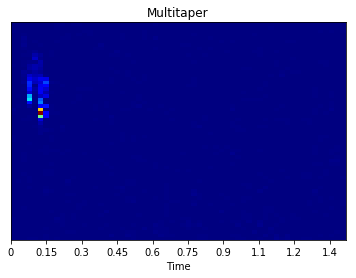

--- chunk nr 2134 recording BUK4_20171017_015504b run 25---  
[[3.52569896e-06 1.48901330e-05 7.71471942e-06 ... 4.91197020e-06
  2.10742329e-06 9.61018100e-06]
 [4.70971936e-06 1.84009221e-05 1.02468887e-05 ... 3.60696051e-06
  2.39193564e-06 4.92278113e-06]
 [2.65906943e-06 9.52340559e-06 1.85767474e-05 ... 1.59864241e-06
  1.61905212e-06 1.63584664e-06]
 ...
 [4.00197047e-06 4.23534381e-06 3.49941582e-06 ... 6.72100254e-06
  2.45265963e-06 1.25707035e-06]
 [7.63311138e-07 3.13126802e-06 2.48214419e-06 ... 2.67297753e-06
  3.36110012e-06 2.04474253e-06]
 [4.89476958e-06 4.09252104e-06 1.35769127e-06 ... 1.69660848e-06
  4.92640221e-06 5.08768677e-06]]


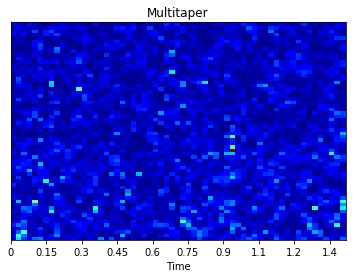

--- chunk nr 2461 recording BUK4_20171017_015504b run 26---  
[[6.62909395e-06 3.22643232e-06 6.96000235e-07 ... 1.67351942e-06
  9.46578009e-07 5.04204318e-06]
 [3.49056795e-06 5.07411172e-06 2.30365609e-06 ... 3.98385533e-07
  2.81119727e-06 2.42028288e-06]
 [6.21536254e-06 2.53841398e-06 2.28950586e-06 ... 4.92687333e-07
  1.67835336e-06 1.66858447e-06]
 ...
 [2.43495170e-06 1.64765050e-06 1.81267825e-06 ... 7.61450970e-06
  2.98997299e-06 2.10600720e-06]
 [4.48941394e-06 2.88268807e-06 1.81486510e-06 ... 1.58604791e-06
  4.02613977e-06 8.05756744e-06]
 [6.58149327e-06 6.70883855e-07 1.49361186e-06 ... 2.05694625e-06
  7.12900525e-07 3.06904255e-06]]


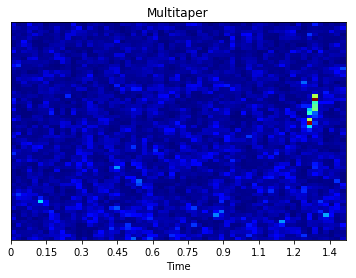

--- chunk nr 2462 recording BUK4_20171017_015504b run 27---  
[[1.09610190e-06 4.06213207e-06 4.55541178e-06 ... 2.39342269e-06
  4.94260921e-06 3.65199315e-06]
 [6.88436578e-06 2.27439377e-06 3.96802089e-06 ... 6.84175660e-06
  1.28830346e-05 3.99243952e-06]
 [1.36428783e-05 1.78580380e-06 3.04054601e-06 ... 3.39532883e-06
  2.77620931e-05 1.81040127e-05]
 ...
 [6.28588178e-06 3.44109531e-06 4.64333902e-07 ... 3.82028647e-07
  1.61256673e-06 1.88317075e-06]
 [1.71143101e-06 3.83606954e-06 4.51629732e-06 ... 1.10752552e-06
  5.54512786e-06 5.37828093e-06]
 [1.84014988e-06 3.55393624e-06 5.22721880e-06 ... 1.64208205e-06
  3.16843820e-06 2.53152817e-06]]


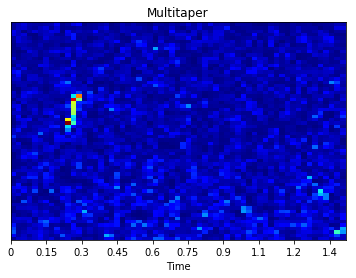

--- chunk nr 2517 recording BUK4_20171017_015504b run 28---  
[[7.09218878e-06 1.01246802e-05 5.61134932e-06 ... 4.62007143e-06
  6.99729115e-06 1.11506568e-05]
 [4.61084461e-06 4.97793773e-06 4.87258369e-06 ... 3.41841098e-06
  2.77343519e-05 6.93723351e-07]
 [1.59447654e-05 5.93003211e-06 7.87402147e-07 ... 3.12533257e-06
  5.48704678e-06 1.71727450e-06]
 ...
 [3.57019685e-06 1.24692748e-06 9.64296798e-07 ... 1.04405436e-06
  1.05803396e-06 4.58469818e-06]
 [7.55679346e-07 1.04086985e-06 8.83531464e-07 ... 5.69343374e-06
  2.69057079e-07 3.30541394e-06]
 [2.61683142e-06 4.27317528e-07 7.48547428e-07 ... 1.26963640e-06
  1.23700295e-06 1.87014790e-07]]


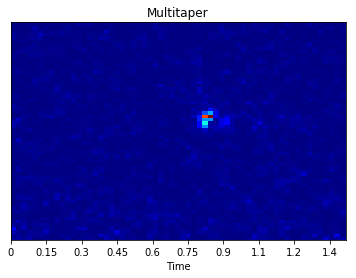

--- chunk nr 2559 recording BUK4_20171017_015504b run 29---  
[[3.63321790e-06 2.07265354e-06 1.79395985e-06 ... 1.40667943e-06
  2.85687447e-06 1.30410462e-06]
 [1.36679265e-06 2.08939541e-06 1.64277328e-06 ... 7.00170070e-07
  1.36887376e-06 4.56142712e-07]
 [9.04059289e-07 2.23180429e-06 6.56625483e-06 ... 5.12605117e-06
  1.62885573e-06 1.25095292e-06]
 ...
 [1.12798493e-06 4.00688174e-06 3.07651227e-06 ... 2.85420283e-06
  3.31085990e-06 3.30032081e-06]
 [1.38174857e-06 2.23159006e-06 1.47374501e-06 ... 1.75005652e-06
  7.67760771e-06 4.70402555e-06]
 [2.00086632e-06 9.19059612e-07 3.83051645e-06 ... 7.61875706e-07
  1.86183558e-06 1.10626025e-05]]


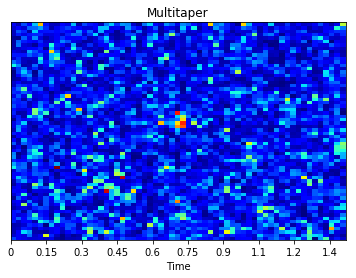

--- chunk nr 2566 recording BUK4_20171017_015504b run 30---  
[[2.05948952e-06 8.86925370e-07 5.50358040e-06 ... 6.04125393e-07
  2.71551274e-06 3.93997402e-06]
 [2.53673658e-06 3.73748128e-07 5.06999523e-06 ... 3.87225454e-07
  6.49932894e-07 1.57305498e-06]
 [3.73592784e-06 1.25844512e-06 3.43880417e-06 ... 2.75300498e-06
  3.32765776e-07 2.65113330e-06]
 ...
 [2.06698667e-06 1.33049929e-06 7.95590762e-07 ... 2.27233351e-06
  1.62536131e-06 4.18909194e-07]
 [1.29301549e-06 7.66730932e-07 2.04765641e-06 ... 2.36205935e-06
  1.13927582e-06 2.85219094e-07]
 [2.88313691e-06 5.77625534e-07 2.61464632e-06 ... 3.19129351e-06
  9.96047513e-07 6.40366714e-07]]


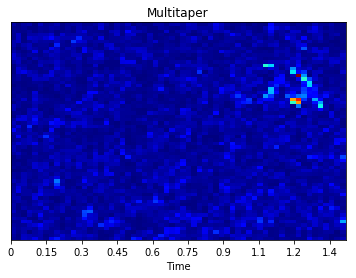

--- chunk nr 2567 recording BUK4_20171017_015504b run 31---  
[[7.01910088e-07 1.72339139e-06 1.18593665e-06 ... 1.79051514e-06
  3.80531579e-06 8.57656386e-06]
 [2.55634792e-06 3.09453151e-06 2.62670779e-06 ... 3.58330763e-06
  1.28203530e-06 3.16057978e-06]
 [2.90701137e-06 1.06390542e-06 4.18401390e-06 ... 2.93148910e-06
  1.21762979e-06 1.96881124e-06]
 ...
 [1.24770400e-06 5.06481112e-07 7.65033527e-07 ... 2.96704910e-06
  2.91914021e-06 8.42240100e-06]
 [1.66324685e-06 7.44879437e-07 7.22780638e-07 ... 2.99841982e-06
  1.10884935e-06 2.19840868e-06]
 [1.51479250e-06 1.15872070e-06 1.75002858e-06 ... 5.63288047e-06
  2.47587700e-07 4.46690723e-06]]


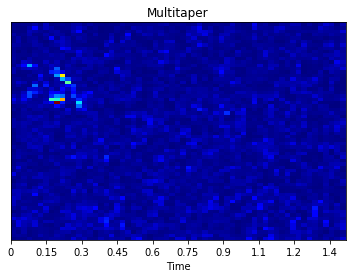

--- chunk nr 2838 recording BUK4_20171017_015504b run 32---  
[[3.25931140e-06 1.82052762e-06 2.13478677e-06 ... 3.20378590e-06
  2.32496350e-06 4.21829107e-06]
 [6.54179798e-06 4.15955247e-06 4.84470929e-07 ... 3.76730696e-06
  6.85248750e-06 3.54499768e-06]
 [1.73579690e-05 6.62831373e-06 2.92696126e-06 ... 1.70477412e-06
  3.68238969e-06 2.52221738e-06]
 ...
 [2.44649165e-06 1.24607059e-06 1.12605430e-06 ... 2.67362919e-06
  8.84355935e-06 1.04424283e-06]
 [2.30927355e-06 8.56750532e-06 1.51010037e-06 ... 2.03100338e-06
  6.99151487e-06 1.82853168e-06]
 [6.12012821e-06 3.71353452e-06 1.44227803e-06 ... 2.12179419e-06
  5.41442434e-06 2.00074329e-06]]


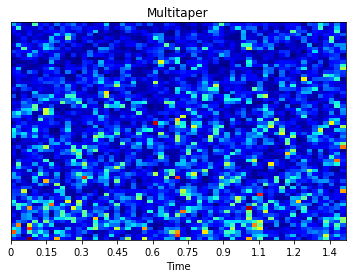

--- chunk nr 2839 recording BUK4_20171017_015504b run 33---  
[[1.41322848e-05 2.28326896e-06 3.62551803e-06 ... 3.20784872e-06
  3.34364754e-06 1.08882410e-05]
 [4.55882854e-06 4.06902753e-06 1.00083267e-05 ... 1.38502540e-06
  2.50298817e-06 2.87059431e-06]
 [5.64096264e-06 3.69280815e-06 9.61563909e-06 ... 3.23836778e-06
  1.13700941e-06 4.32312474e-06]
 ...
 [4.95916417e-06 3.02707520e-06 2.14773651e-06 ... 3.40449274e-06
  3.02760236e-06 5.05269395e-07]
 [5.28127426e-06 1.38522256e-06 1.27342109e-06 ... 1.51287582e-06
  1.06444737e-06 7.38664780e-07]
 [5.27491517e-06 1.73074361e-06 4.58847579e-06 ... 1.32522238e-06
  4.00908361e-07 3.18491470e-07]]


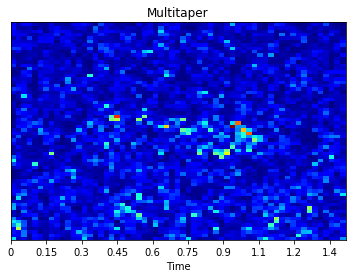

--- chunk nr 2840 recording BUK4_20171017_015504b run 34---  
[[1.21814207e-06 3.75512737e-06 1.05191977e-05 ... 1.06231251e-05
  6.81390045e-06 1.95475263e-06]
 [9.38539362e-07 3.21633267e-06 4.25161442e-06 ... 1.29659052e-05
  3.86789198e-06 1.29069264e-05]
 [4.34948748e-06 6.25913580e-06 6.95933208e-06 ... 1.48844771e-05
  1.07669649e-05 1.03753450e-05]
 ...
 [1.03248047e-06 1.68788556e-06 4.82414952e-07 ... 1.11181910e-06
  5.65921213e-06 5.71934894e-07]
 [8.32492661e-06 2.57813363e-06 4.60164775e-07 ... 4.00119654e-06
  1.55091334e-06 1.75229525e-06]
 [3.44589949e-06 2.72316710e-06 6.75997908e-07 ... 2.40622262e-06
  1.22613476e-06 3.33838904e-06]]


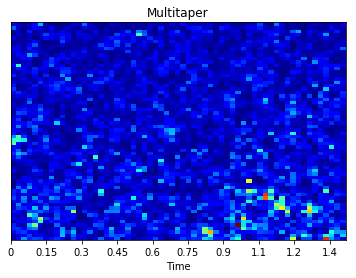

--- chunk nr 2936 recording BUK4_20171017_015504b run 35---  
[[4.80758201e-06 7.11087845e-06 4.90740101e-06 ... 5.85088452e-07
  4.21426087e-06 1.90580539e-06]
 [1.18746657e-06 6.56766651e-06 1.25416907e-05 ... 3.48545669e-06
  1.66079250e-06 1.66714557e-06]
 [1.33141085e-06 6.56621584e-06 2.27387135e-06 ... 1.77132692e-06
  1.16393424e-06 1.99505190e-06]
 ...
 [1.79033979e-06 1.74387309e-06 1.98280557e-06 ... 1.94979158e-06
  7.68517653e-07 2.94859576e-06]
 [1.64025564e-06 3.16132915e-06 2.06445258e-06 ... 3.16637793e-06
  1.32116362e-06 3.12014507e-06]
 [1.31108569e-06 2.89334024e-06 2.77784633e-06 ... 9.34444808e-07
  9.55021640e-07 4.14128740e-06]]


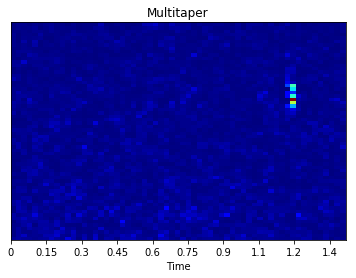

--- chunk nr 2937 recording BUK4_20171017_015504b run 36---  
[[3.50246657e-06 6.11995253e-06 2.98307379e-06 ... 4.01510424e-06
  3.56790425e-06 3.80672507e-06]
 [4.36751256e-06 6.79537641e-06 4.72948796e-06 ... 1.93179172e-06
  7.98644097e-06 7.36176221e-06]
 [2.18551719e-06 5.66137098e-06 1.09971814e-05 ... 4.66211745e-06
  2.03881278e-05 9.54515759e-06]
 ...
 [2.71863652e-06 1.33498521e-06 2.00170556e-07 ... 3.19092971e-06
  3.10921354e-06 5.13810338e-07]
 [1.62968919e-06 1.97949151e-06 1.04496747e-06 ... 1.33143525e-06
  1.82870421e-06 1.19890631e-06]
 [4.99648728e-06 5.58327233e-06 3.93822794e-06 ... 4.11535531e-07
  1.93651013e-06 1.50835923e-06]]


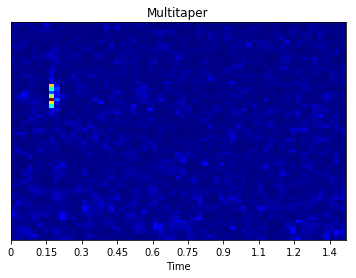

--- chunk nr 2946 recording BUK4_20171017_015504b run 37---  
[[1.06928557e-05 3.69591645e-06 3.31370829e-06 ... 7.25137952e-06
  2.13707216e-06 9.90697775e-07]
 [5.11698637e-06 7.79859434e-06 5.46469763e-06 ... 1.56274111e-05
  3.18659094e-06 2.88813023e-06]
 [7.91921244e-06 6.89234117e-06 2.34730108e-05 ... 6.86462771e-06
  9.39347201e-06 1.26290899e-06]
 ...
 [4.11748131e-06 2.25003003e-06 6.29336913e-07 ... 6.05043633e-06
  2.16910922e-06 3.97043454e-06]
 [3.75956020e-06 2.02913673e-06 1.48943435e-06 ... 3.09851342e-07
  1.10239671e-06 6.72263815e-06]
 [1.29676071e-06 2.01614739e-07 4.42568818e-06 ... 2.94755095e-07
  2.18679290e-06 7.45371121e-06]]


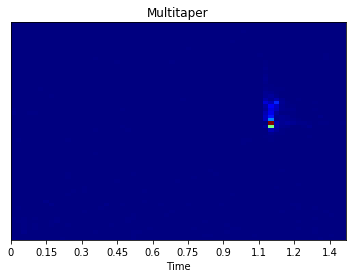

--- chunk nr 2947 recording BUK4_20171017_015504b run 38---  
[[3.08727078e-06 3.69591512e-06 9.75269898e-07 ... 3.00717771e-06
  1.10020045e-06 1.08740993e-05]
 [6.00386637e-06 5.38441954e-06 7.91211373e-07 ... 3.30231868e-06
  2.02029794e-06 8.51897191e-06]
 [1.36746817e-06 3.28408251e-06 5.53283980e-06 ... 8.87619763e-06
  1.01362102e-05 8.31965986e-06]
 ...
 [2.40493957e-06 3.28813628e-06 2.62749254e-06 ... 8.95831783e-06
  1.21200585e-05 2.22003430e-06]
 [2.69887562e-06 5.17618018e-06 1.71236156e-06 ... 4.28537117e-06
  1.28966661e-06 9.24741829e-06]
 [4.83022937e-06 3.54995270e-06 5.57099508e-06 ... 6.30457655e-06
  1.45338781e-06 2.47473307e-06]]


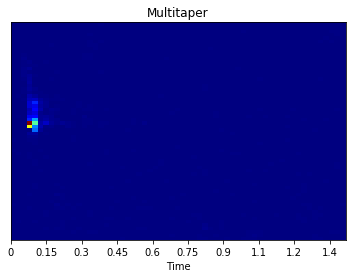

--- chunk nr 2951 recording BUK4_20171017_015504b run 39---  
[[4.59253878e-06 1.11700026e-06 1.08177242e-06 ... 5.57726218e-06
  2.03476152e-06 1.83323187e-06]
 [2.89015189e-06 2.12678708e-06 4.80978912e-07 ... 1.61251258e-06
  1.86774647e-06 3.29461331e-06]
 [9.44254315e-07 1.24783197e-06 1.60811989e-06 ... 3.34823775e-06
  2.32653501e-06 5.86147950e-07]
 ...
 [1.05505348e-06 1.89894391e-06 8.56677363e-07 ... 2.72108680e-06
  1.64001352e-06 2.21138109e-06]
 [7.08513321e-06 6.60280528e-07 2.29824809e-06 ... 5.34121434e-06
  3.53614046e-06 1.34153429e-06]
 [5.01693065e-06 1.22686662e-06 2.36688915e-06 ... 3.51729633e-06
  9.42733118e-06 2.38357159e-07]]


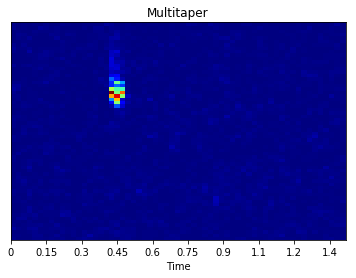

--- chunk nr 2965 recording BUK4_20171017_015504b run 40---  
[[1.07284014e-05 4.13365402e-06 5.84218636e-06 ... 6.07789147e-06
  2.92190128e-06 1.45870244e-06]
 [1.01700681e-05 5.24429482e-06 4.34817388e-06 ... 7.72568221e-06
  9.99882754e-06 8.19442924e-06]
 [5.78343787e-06 7.77272859e-06 2.52693095e-06 ... 1.64958686e-05
  8.24992441e-06 5.65289759e-06]
 ...
 [3.68127096e-06 3.30129332e-06 4.16435207e-07 ... 2.13699677e-06
  1.37043839e-06 4.31492239e-07]
 [1.47707832e-07 4.25693614e-06 1.03422699e-06 ... 3.91820534e-06
  4.35225909e-06 1.70373680e-07]
 [3.67064629e-06 1.26311146e-06 3.82211997e-06 ... 2.19017653e-06
  2.96817413e-06 1.02708687e-05]]


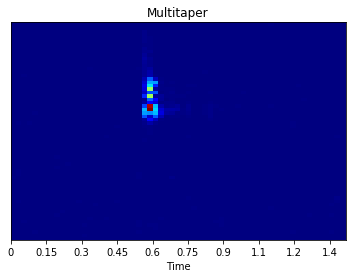

--- chunk nr 2988 recording BUK4_20171017_015504b run 41---  
[[3.12939670e-06 9.90641324e-07 3.03740812e-06 ... 1.80264841e-06
  4.16981154e-06 5.69112129e-06]
 [3.42542846e-06 1.60214629e-06 3.86251566e-06 ... 4.66181276e-06
  2.42716913e-06 9.74602235e-06]
 [5.32201596e-06 3.72000784e-06 7.65732540e-06 ... 2.64492089e-06
  5.13921018e-06 4.81198647e-06]
 ...
 [1.63912512e-06 2.92777285e-07 1.16723630e-06 ... 3.15323465e-06
  3.09999389e-06 2.32287628e-06]
 [5.35881465e-07 1.21711724e-06 1.32623481e-06 ... 5.59040629e-06
  1.64514256e-06 6.43705624e-07]
 [2.47114213e-07 4.73211596e-06 3.76136747e-06 ... 5.01601135e-06
  6.10782630e-07 8.64618155e-08]]


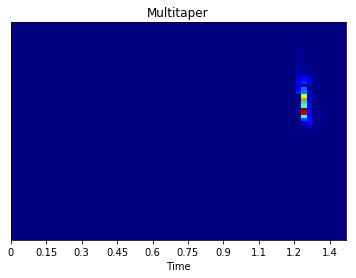

--- chunk nr 2989 recording BUK4_20171017_015504b run 42---  
[[8.39911644e-07 6.41114114e-06 3.13201409e-06 ... 4.64326433e-06
  5.75243135e-06 4.23133713e-06]
 [1.19739363e-05 1.28627425e-05 2.04328773e-06 ... 2.96248308e-06
  8.88471434e-06 3.47026520e-06]
 [8.46405175e-06 6.73857175e-06 3.04193938e-06 ... 3.83605472e-06
  5.38712921e-06 4.31078826e-06]
 ...
 [1.85565153e-06 4.34798851e-06 2.70572318e-06 ... 2.96537375e-06
  1.49327734e-06 9.30540652e-07]
 [3.80927138e-06 1.80092672e-06 3.35430926e-06 ... 2.85530859e-06
  1.13276180e-06 3.38663385e-06]
 [3.93095136e-06 1.97784256e-06 4.04280588e-06 ... 1.54787839e-05
  2.58689221e-06 3.80837808e-06]]


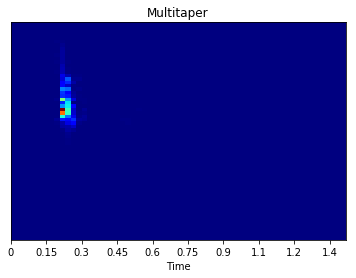

--- chunk nr 3502 recording BUK4_20171017_015504b run 43---  
[[1.85946625e-05 9.20189687e-06 2.03577295e-06 ... 4.00533583e-07
  1.29765399e-06 2.74379381e-06]
 [1.40347847e-05 5.31360022e-06 3.38122784e-06 ... 1.12632266e-06
  1.44428300e-06 4.77729295e-06]
 [8.54496293e-06 5.41024198e-06 6.57997116e-06 ... 3.12952164e-06
  3.74839487e-06 1.01993900e-05]
 ...
 [2.09173201e-06 3.07156387e-07 0.00000000e+00 ... 4.76749673e-06
  3.34374371e-06 1.88839260e-06]
 [6.50365528e-06 1.97614819e-06 6.74725560e-07 ... 1.69618317e-06
  9.21915982e-06 5.43629661e-06]
 [2.66186091e-06 2.10033730e-05 3.55617728e-06 ... 1.36121659e-06
  3.20929866e-06 3.71017190e-06]]


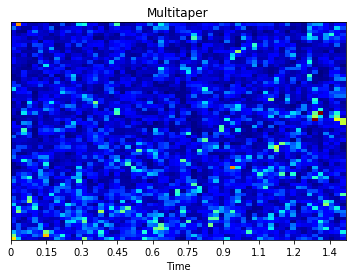

--- chunk nr 3503 recording BUK4_20171017_015504b run 44---  
[[1.77207106e-06 3.36652620e-06 7.08749752e-06 ... 1.54247263e-07
  2.80422251e-06 2.86050588e-06]
 [6.45687966e-06 1.61433875e-06 5.44666874e-06 ... 8.67740517e-07
  1.47549006e-06 5.25423435e-06]
 [6.58991201e-06 3.27867667e-06 3.51788647e-06 ... 6.71469703e-06
  2.48481450e-06 8.62831573e-06]
 ...
 [5.31810341e-07 3.97128754e-07 1.41489045e-06 ... 2.52633410e-06
  5.57403394e-07 5.31979686e-07]
 [7.25381710e-07 5.25010901e-07 3.04638936e-06 ... 5.00551843e-06
  1.87557205e-06 3.02738245e-06]
 [5.74215712e-06 8.19783958e-07 3.90761737e-06 ... 1.00549046e-05
  3.68071367e-06 2.06673183e-06]]


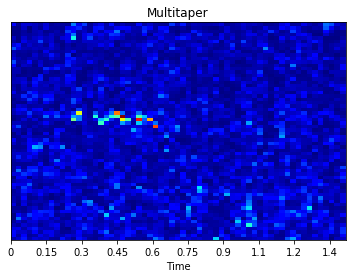

--- chunk nr 3656 recording BUK4_20171017_015504b run 45---  
[[3.28371937e-06 7.90704656e-06 6.03036631e-06 ... 5.28134380e-06
  4.78307698e-06 1.92345664e-06]
 [8.93919467e-07 1.32924224e-06 7.29008396e-06 ... 1.24147558e-05
  6.45989834e-06 4.58925863e-06]
 [9.71388707e-07 3.84753310e-06 2.56974330e-06 ... 7.84362991e-06
  4.84303683e-06 2.59329419e-05]
 ...
 [2.07148319e-06 6.91706378e-06 1.62982197e-06 ... 2.58309907e-06
  3.36706678e-06 8.16734979e-06]
 [7.04925677e-06 8.02400951e-06 2.98660873e-06 ... 1.45777728e-06
  1.85091343e-06 1.98102902e-06]
 [2.80843573e-06 1.32487185e-06 2.63098736e-06 ... 2.05820316e-06
  1.24642187e-06 2.39193500e-06]]


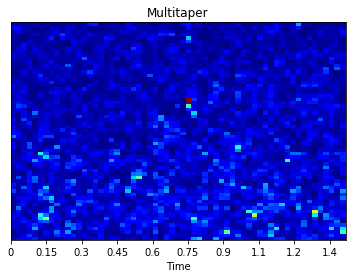

--- chunk nr 3697 recording BUK4_20171017_015504b run 46---  
[[5.91853146e-07 1.79129790e-06 1.87882247e-06 ... 1.69408218e-06
  9.22033719e-07 1.01839297e-06]
 [1.51474169e-06 3.76145692e-06 3.79457833e-06 ... 2.39645584e-06
  4.67267717e-06 6.59169888e-06]
 [9.87224220e-07 1.30705870e-06 4.95509659e-06 ... 1.27507334e-06
  6.98888846e-06 9.76946509e-06]
 ...
 [4.90034523e-07 2.87627324e-06 1.11577482e-06 ... 3.28357024e-06
  1.12250410e-06 2.36651729e-06]
 [2.79838658e-07 1.35650346e-06 1.96519279e-06 ... 7.98805797e-07
  2.08553841e-06 9.20752924e-07]
 [4.12741491e-07 3.78112142e-06 4.15532095e-06 ... 4.67169288e-06
  8.71098446e-06 3.62184870e-06]]


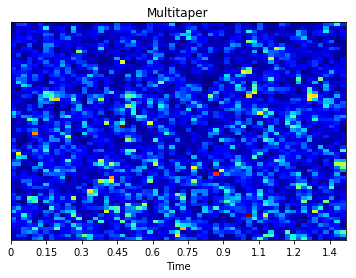

--- chunk nr 3710 recording BUK4_20171017_015504b run 47---  
[[1.46367823e-06 1.88438219e-06 1.29684390e-06 ... 2.52031762e-06
  2.01943714e-06 2.03413027e-06]
 [5.54607743e-07 1.66363117e-06 3.74443062e-06 ... 6.32397690e-06
  6.95184156e-06 3.69630624e-06]
 [1.31829770e-06 1.88913107e-06 2.94489672e-06 ... 4.75619845e-06
  6.93130808e-06 1.57895841e-06]
 ...
 [2.75497388e-06 2.20907635e-06 6.78232897e-06 ... 2.45403377e-06
  2.84031073e-06 1.53698727e-06]
 [4.90761365e-06 1.34717504e-06 3.64961298e-06 ... 5.07563738e-06
  2.89379453e-06 3.00337872e-06]
 [5.58888119e-06 1.19821980e-06 2.23882153e-06 ... 4.47598574e-06
  5.57444261e-06 3.42288100e-06]]


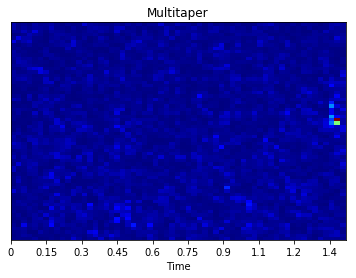

--- chunk nr 3711 recording BUK4_20171017_015504b run 48---  
[[6.74934067e-06 2.80475202e-06 4.79836402e-07 ... 2.03456322e-06
  8.98802207e-06 7.68119152e-06]
 [1.36758442e-06 2.55202045e-06 1.76717089e-06 ... 2.00455015e-06
  6.54230198e-07 3.18243738e-06]
 [2.30719857e-06 2.92906618e-06 3.73795284e-06 ... 4.65222782e-06
  2.12231046e-06 1.06262714e-06]
 ...
 [4.67023630e-07 5.11536481e-06 1.41505222e-06 ... 3.86508806e-06
  7.04171500e-06 3.59046242e-06]
 [1.91855292e-06 6.09459036e-06 1.00054793e-06 ... 5.27311777e-06
  5.24163706e-06 3.05647183e-06]
 [1.78288199e-06 1.90587598e-06 9.26663709e-06 ... 1.18630500e-06
  1.72946884e-06 5.78484519e-06]]


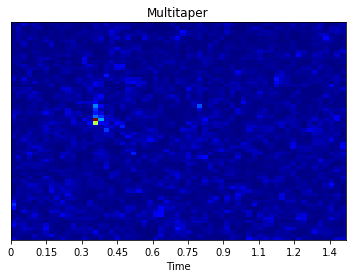

--- chunk nr 3724 recording BUK4_20171017_015504b run 49---  
[[3.74694323e-06 2.14777549e-06 1.67369146e-06 ... 1.11285918e-05
  1.08708889e-06 3.61888569e-06]
 [2.76857148e-06 3.38822045e-06 5.03161264e-06 ... 7.45077961e-06
  1.58395219e-06 4.23372732e-06]
 [1.55322801e-05 1.16803071e-06 5.11343406e-06 ... 1.15437319e-05
  2.88059847e-06 6.58935979e-06]
 ...
 [1.21506891e-06 1.08033804e-06 1.88519434e-06 ... 2.97020763e-06
  3.49415250e-06 4.90769400e-06]
 [1.88256745e-06 5.51662835e-07 1.93871083e-06 ... 4.64522476e-06
  6.45196068e-07 5.44622923e-06]
 [8.17756573e-07 8.76114588e-07 4.34691930e-06 ... 4.11767363e-06
  1.62887402e-06 7.42134914e-06]]


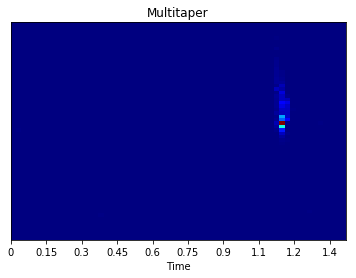

--- chunk nr 3725 recording BUK4_20171017_015504b run 50---  
[[1.68390815e-05 1.52153150e-06 2.75172315e-06 ... 1.53924594e-06
  4.55807742e-07 3.06365132e-06]
 [1.74885698e-05 2.86064488e-06 3.74279065e-06 ... 2.26820168e-06
  1.26131350e-06 2.22715373e-06]
 [1.24541548e-05 2.41248285e-06 2.35738240e-06 ... 2.74378090e-06
  2.65600400e-06 4.53648344e-06]
 ...
 [2.04090528e-07 7.32513759e-06 3.05271840e-06 ... 2.70014741e-06
  2.81431691e-06 5.76140459e-07]
 [1.45530166e-06 8.80751233e-07 3.21895409e-07 ... 8.86227136e-07
  1.78884679e-06 1.99893941e-06]
 [4.91924356e-06 3.55029777e-06 7.94072307e-07 ... 2.07781984e-06
  2.96740238e-06 5.45287942e-06]]


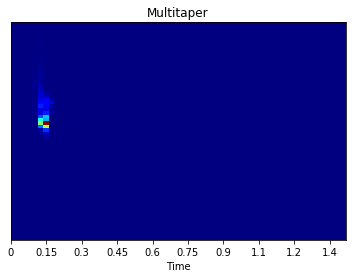

--- chunk nr 3990 recording BUK4_20171017_015504b run 51---  
[[3.20286135e-06 7.84452555e-06 2.23663896e-06 ... 3.98476588e-06
  1.80813057e-06 1.86267475e-06]
 [2.31256202e-06 4.94297661e-06 3.21201370e-06 ... 2.23099635e-06
  7.15036656e-06 2.38924586e-06]
 [4.80941804e-06 3.82775586e-06 5.58460886e-06 ... 4.15057415e-06
  5.22955200e-06 4.92104157e-06]
 ...
 [4.14903044e-06 1.30506700e-06 3.59979231e-06 ... 2.10147675e-06
  3.45304391e-06 5.55592685e-07]
 [6.54033891e-06 4.82275194e-06 3.22205859e-06 ... 3.58123804e-06
  3.32868630e-06 3.28078328e-06]
 [5.17882210e-06 8.87120899e-06 4.96479276e-06 ... 2.08097527e-06
  4.20094916e-06 3.99682252e-06]]


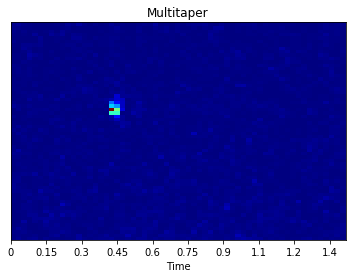

--- chunk nr 4034 recording BUK4_20171017_015504b run 52---  
[[4.16106046e-06 2.75746463e-06 1.90817909e-06 ... 9.77396520e-06
  3.17257985e-06 3.10255081e-06]
 [7.58758436e-07 3.89711648e-06 3.97676895e-06 ... 1.52125834e-06
  2.64292618e-06 7.66780224e-06]
 [5.06286361e-06 3.30625988e-06 3.18284247e-06 ... 1.23900166e-06
  4.27245613e-06 1.05636191e-05]
 ...
 [1.31804075e-06 3.49107680e-06 4.97596138e-06 ... 3.69500977e-06
  2.99947185e-06 1.01409757e-05]
 [9.45958500e-07 4.46348110e-06 3.06059355e-06 ... 6.94386447e-07
  1.45803850e-05 9.46215362e-06]
 [1.16964888e-06 2.21538599e-06 1.82561873e-06 ... 9.09200769e-07
  4.73806826e-06 1.32994765e-06]]


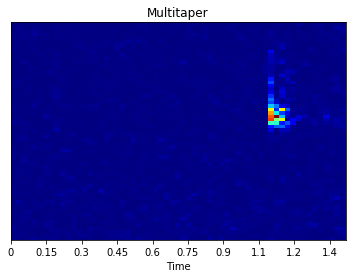

--- chunk nr 4035 recording BUK4_20171017_015504b run 53---  
[[1.36266393e-06 2.05283185e-06 7.52009866e-06 ... 3.06852472e-06
  7.58514591e-06 1.55747509e-05]
 [4.19063601e-06 3.48135076e-06 1.88616544e-06 ... 7.37213089e-06
  5.47861100e-06 2.61134154e-06]
 [1.44148903e-06 3.45581275e-06 9.91671957e-07 ... 6.29760197e-06
  3.71595561e-06 7.31834511e-07]
 ...
 [6.38140402e-06 1.11156110e-06 3.76324766e-07 ... 2.60029983e-06
  4.47551582e-06 2.16774350e-06]
 [2.70438676e-06 2.80105100e-06 1.29492406e-06 ... 1.50801326e-06
  2.64683343e-06 5.60653464e-07]
 [2.84183312e-06 3.15648450e-06 2.96034468e-07 ... 8.60176115e-07
  8.91490802e-06 2.42878188e-06]]


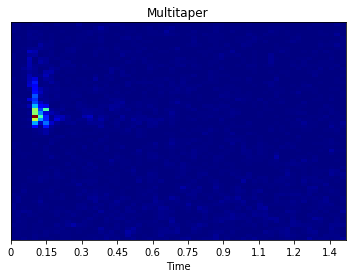

--- chunk nr 4039 recording BUK4_20171017_015504b run 54---  
[[1.63695091e-06 1.58824215e-06 7.15793316e-06 ... 3.50510124e-06
  3.79361561e-06 4.05736798e-06]
 [2.19660561e-06 6.04841143e-06 1.57648166e-06 ... 2.58005388e-06
  2.53184805e-06 1.52169202e-06]
 [1.50903584e-06 8.25090308e-06 1.35453563e-06 ... 2.83229600e-06
  7.06789327e-06 3.39738636e-06]
 ...
 [2.04262030e-06 2.98816415e-07 5.91030581e-07 ... 5.13495946e-07
  2.69249944e-06 2.64717245e-06]
 [2.39318372e-06 7.37474265e-07 2.38945594e-06 ... 1.48458645e-06
  4.50397052e-06 6.07111282e-07]
 [1.98123876e-06 1.75562276e-06 2.59296213e-06 ... 1.42185018e-06
  3.72110365e-06 2.12370083e-06]]


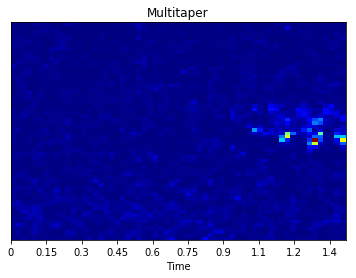

--- chunk nr 4040 recording BUK4_20171017_015504b run 55---  
[[1.21570364e-06 4.83014787e-06 2.13394669e-06 ... 9.69719101e-06
  4.90865609e-06 7.92754965e-07]
 [4.22816408e-06 4.20402987e-06 4.92887477e-06 ... 1.02325445e-05
  4.06544029e-06 2.60235391e-06]
 [3.77183636e-06 2.79280936e-06 1.73198130e-06 ... 6.52578216e-06
  8.13892804e-06 1.10421624e-06]
 ...
 [1.35390401e-06 2.00072498e-06 8.87999860e-07 ... 2.44714476e-06
  3.19198217e-06 1.95811231e-06]
 [2.44783380e-06 6.42366656e-07 1.68658915e-07 ... 1.61361822e-06
  4.77300304e-06 3.03686452e-06]
 [2.11328772e-06 2.43808089e-06 6.21126054e-07 ... 1.28633946e-06
  1.98563023e-06 4.28628284e-06]]


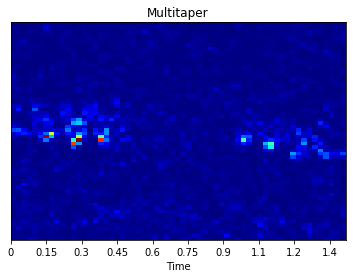

--- chunk nr 4041 recording BUK4_20171017_015504b run 56---  
[[2.61868964e-06 4.63732333e-06 1.17259835e-05 ... 7.96879275e-06
  3.50316048e-06 1.37428677e-06]
 [3.86204111e-06 1.92082811e-05 4.72399394e-06 ... 7.85109129e-06
  7.63414182e-06 1.44933295e-06]
 [1.93332650e-06 6.49750095e-06 5.09999112e-06 ... 8.31884989e-07
  3.48833327e-06 4.93173044e-06]
 ...
 [1.06087799e-06 1.73527814e-06 3.02713101e-06 ... 9.65484395e-06
  5.12350229e-07 1.73174282e-06]
 [8.62901472e-07 4.32278761e-06 4.22401696e-06 ... 4.32964192e-06
  4.16058831e-07 3.61193367e-06]
 [1.38566307e-06 2.87731452e-06 9.52023377e-07 ... 1.38655293e-06
  3.74459058e-06 5.81046379e-06]]


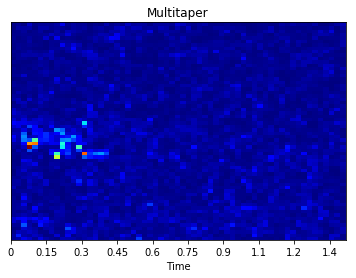

--- chunk nr 4059 recording BUK4_20171017_015504b run 57---  
[[9.67562452e-06 2.42440955e-06 1.71566855e-06 ... 6.76983042e-06
  1.11556792e-05 1.39339543e-06]
 [8.82163828e-06 6.93617012e-06 4.02780248e-06 ... 1.73942585e-06
  2.29006577e-06 5.06540783e-06]
 [5.23210457e-06 1.02559144e-05 1.25355338e-05 ... 4.13595226e-06
  3.91447922e-08 2.20945416e-06]
 ...
 [2.95280788e-06 4.79490264e-06 2.91577857e-07 ... 4.41856517e-06
  6.27850965e-06 7.00823027e-07]
 [2.95846832e-06 2.93838302e-06 4.43489962e-07 ... 3.82095085e-06
  8.85758558e-07 7.32858863e-07]
 [4.88110581e-06 1.63756722e-06 4.98643247e-07 ... 2.24699896e-06
  1.13162742e-06 1.26778770e-06]]


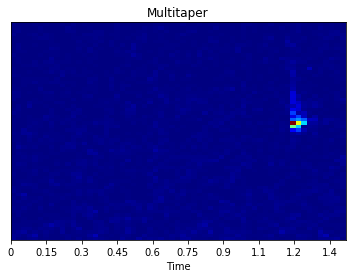

--- chunk nr 4060 recording BUK4_20171017_015504b run 58---  
[[3.95749378e-06 1.65050150e-06 1.17616886e-06 ... 1.22735378e-06
  3.62981275e-06 7.86636952e-06]
 [4.30463144e-06 3.24145207e-06 3.64127575e-06 ... 1.26986166e-06
  2.40939336e-06 1.58036318e-05]
 [1.74554382e-06 2.49955958e-06 5.38622364e-06 ... 1.16983113e-05
  1.11294425e-05 9.56402613e-06]
 ...
 [6.06008035e-07 8.67642679e-07 9.36847504e-07 ... 3.84297595e-06
  1.40170208e-06 8.91498006e-07]
 [2.31426969e-06 1.60938972e-06 1.20099616e-06 ... 6.18296776e-06
  1.97939216e-06 4.45657353e-06]
 [2.96522105e-06 1.57978228e-06 4.71579290e-07 ... 1.94635796e-06
  4.06801407e-07 3.75591693e-06]]


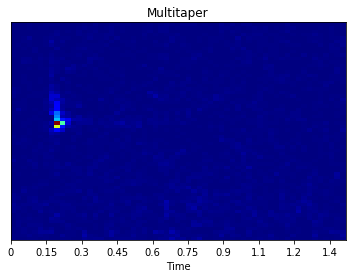

--- chunk nr 4225 recording BUK4_20171017_015504b run 59---  
[[2.95862484e-06 1.97469764e-06 3.07585148e-06 ... 3.28729080e-06
  3.14686181e-06 1.07412368e-05]
 [2.62229864e-06 2.09664341e-06 2.54484554e-06 ... 2.62442301e-06
  5.57242385e-07 4.17002715e-06]
 [4.23427177e-06 8.84295498e-06 2.11269634e-06 ... 1.50562967e-05
  7.04702381e-07 7.52705054e-06]
 ...
 [1.25163422e-06 5.44891740e-06 4.50144465e-06 ... 5.19319840e-06
  2.88208524e-06 5.64600119e-06]
 [1.85321997e-06 3.27860859e-07 1.70971294e-06 ... 3.80633279e-06
  3.16790758e-06 3.68247872e-06]
 [1.89188328e-06 1.23596754e-06 1.87652835e-06 ... 1.47832708e-06
  3.58810429e-06 3.35052705e-06]]


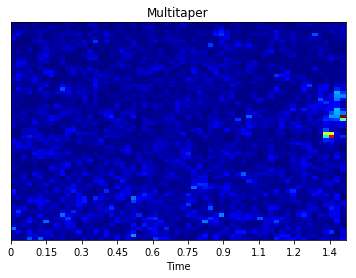

--- chunk nr 4226 recording BUK4_20171017_015504b run 60---  
[[7.51431190e-07 3.59909537e-06 3.16376810e-06 ... 1.67964634e-06
  5.98201098e-06 1.50593469e-06]
 [3.95164998e-06 1.15114814e-06 4.28302090e-06 ... 3.05503653e-06
  3.66413165e-06 2.73639019e-06]
 [8.10013494e-06 6.47540389e-06 1.22702719e-06 ... 3.44155391e-06
  3.28971144e-06 5.33324048e-06]
 ...
 [8.39042967e-07 1.51557665e-06 1.02019890e-06 ... 3.97257832e-06
  1.69910510e-06 3.05049467e-06]
 [1.12326862e-06 7.76539913e-07 8.83858007e-07 ... 5.20086929e-06
  2.14901029e-06 6.96828617e-06]
 [1.68089240e-06 3.09947649e-06 3.53824779e-06 ... 2.39713262e-06
  3.79885544e-06 5.64400013e-06]]


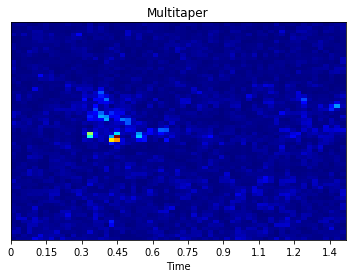

--- chunk nr 4227 recording BUK4_20171017_015504b run 61---  
[[4.02750986e-06 5.37758248e-06 6.96773806e-07 ... 3.55310664e-06
  8.62212982e-06 4.41139745e-06]
 [3.37919973e-06 2.62203644e-06 1.17651557e-05 ... 2.35875734e-06
  8.91972296e-06 1.42999269e-06]
 [2.89917935e-06 4.65516279e-06 1.23719180e-05 ... 3.92897649e-06
  2.84021500e-06 1.35263412e-06]
 ...
 [1.17687624e-06 6.26981929e-07 1.95535969e-06 ... 1.65378462e-06
  3.80971606e-06 3.05847257e-06]
 [1.28288681e-06 7.88846277e-07 1.34157953e-06 ... 1.86241870e-06
  2.03448049e-06 2.22624841e-06]
 [4.41669070e-06 1.34017966e-06 1.26334700e-06 ... 2.16817331e-06
  7.96371011e-07 9.30598252e-07]]


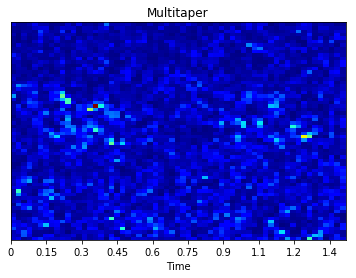

--- chunk nr 4228 recording BUK4_20171017_015504b run 62---  
[[7.13116238e-06 2.70560740e-06 6.95342141e-06 ... 5.37848176e-06
  1.64538888e-06 1.72520662e-06]
 [1.60421058e-06 2.47415438e-06 5.43577518e-06 ... 4.43878799e-06
  5.01223784e-06 3.10891538e-06]
 [1.43371367e-06 7.59894266e-07 8.44619972e-07 ... 1.17248504e-05
  3.17171243e-06 5.05379198e-06]
 ...
 [2.52500955e-06 8.99148238e-07 2.48409216e-06 ... 9.32721004e-07
  1.93934782e-06 1.63482408e-06]
 [4.57577792e-06 3.20966309e-06 3.34674054e-06 ... 2.54192363e-06
  2.29136268e-06 3.21386105e-06]
 [3.03083355e-06 5.48050978e-06 2.53305456e-06 ... 5.23713552e-06
  4.08576985e-06 2.59599778e-06]]


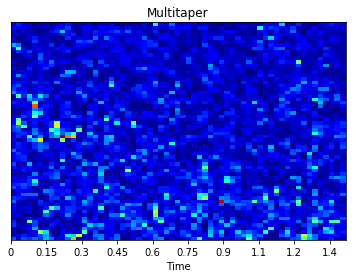

--- chunk nr 4418 recording BUK4_20171017_015504b run 63---  
[[5.60861851e-06 2.16140391e-06 3.25956606e-06 ... 2.94130886e-06
  2.28516412e-06 3.41678451e-06]
 [1.37091797e-05 9.81671806e-07 7.97895477e-06 ... 5.34388860e-06
  4.50160869e-06 1.58851872e-06]
 [1.28258558e-06 2.23785823e-06 3.76665342e-06 ... 3.43482298e-06
  1.40757576e-06 6.01462546e-06]
 ...
 [3.68433080e-06 1.48050698e-06 9.89176947e-07 ... 2.99573058e-06
  9.54667561e-06 1.56310375e-06]
 [4.38029041e-07 1.01736204e-06 1.68287944e-06 ... 8.14203256e-07
  8.55121491e-06 3.95475526e-06]
 [6.69292872e-07 7.53288087e-07 2.98505144e-06 ... 2.99652609e-06
  1.78010500e-06 6.16419154e-06]]


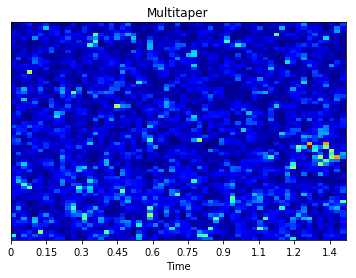

--- chunk nr 4419 recording BUK4_20171017_015504b run 64---  
[[3.40546895e-06 5.04780691e-06 4.04087174e-06 ... 5.15644887e-06
  1.25200459e-06 3.37962576e-06]
 [3.13279529e-06 3.44224822e-06 2.67342270e-06 ... 2.36130624e-06
  5.75121351e-06 9.45770879e-07]
 [1.48438168e-06 4.03333638e-06 4.32776273e-06 ... 4.24869978e-06
  4.56795507e-06 4.08742448e-06]
 ...
 [1.90401368e-06 3.52177627e-06 1.92499295e-06 ... 2.28004293e-06
  3.00522618e-06 7.14739826e-07]
 [1.83652174e-06 8.46310582e-06 2.11793603e-06 ... 2.38361678e-06
  5.57394666e-06 9.74126766e-07]
 [3.22601326e-06 1.23202009e-06 2.21852685e-06 ... 1.57240611e-06
  2.37218728e-06 3.17099433e-07]]


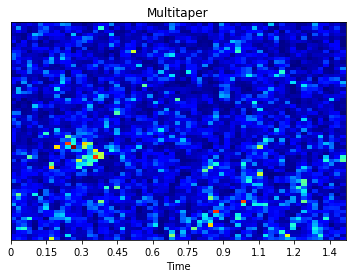

--- chunk nr 4703 recording BUK4_20171017_015504b run 65---  
[[8.69456958e-06 6.17157820e-06 2.96915233e-06 ... 4.86278641e-06
  2.71611117e-06 8.35164786e-06]
 [9.91381835e-06 1.13397068e-05 3.43255320e-06 ... 1.74057833e-06
  8.12364628e-06 7.93308563e-06]
 [3.01185471e-06 6.17642634e-06 2.06479341e-06 ... 3.85157175e-06
  7.33641656e-06 1.80767744e-05]
 ...
 [9.56963295e-06 4.69295584e-06 3.55186553e-06 ... 2.29162297e-06
  2.28670320e-06 1.74234974e-06]
 [1.70844043e-06 5.55785657e-06 4.66468312e-06 ... 6.65517098e-07
  2.96305191e-07 3.65790138e-06]
 [1.43458532e-06 2.59265986e-06 7.68301641e-06 ... 9.91735306e-07
  1.56317444e-06 8.40577483e-07]]


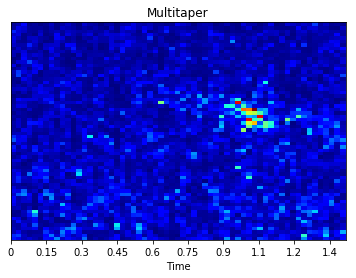

--- chunk nr 4704 recording BUK4_20171017_015504b run 66---  
[[3.34233575e-06 1.59007848e-06 1.31384555e-05 ... 5.35377396e-07
  5.99466476e-06 6.85303978e-06]
 [3.92582084e-06 2.28463990e-06 7.76508208e-06 ... 5.19529369e-06
  2.46775922e-05 6.78312124e-06]
 [2.32842699e-06 4.81528008e-06 5.48239850e-06 ... 1.01075740e-05
  1.02208162e-05 9.92287098e-06]
 ...
 [2.14968837e-07 2.38859773e-06 2.64730738e-06 ... 1.68242079e-06
  6.84079330e-07 2.37576587e-06]
 [1.63538026e-06 1.10577613e-06 2.22506237e-06 ... 1.16825155e-06
  1.61901853e-06 1.92776727e-06]
 [2.49134142e-06 1.39917967e-06 7.60030451e-07 ... 1.93798330e-06
  3.86034437e-06 1.70226161e-06]]


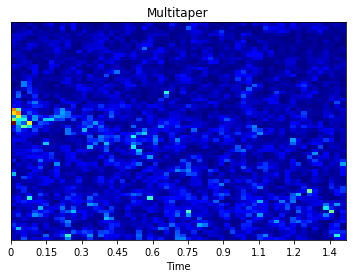

--- chunk nr 4809 recording BUK4_20171017_015504b run 67---  
[[3.80490012e-06 2.01794181e-06 9.17033084e-06 ... 4.79798885e-06
  9.81090958e-06 6.74293990e-06]
 [6.73637106e-06 8.26549710e-06 4.92497829e-06 ... 4.46409420e-06
  2.65508433e-06 1.55470246e-06]
 [8.36233255e-06 4.22961052e-06 3.50101349e-06 ... 2.45796652e-06
  2.89787265e-06 1.33304209e-06]
 ...
 [1.15090340e-06 8.85275157e-07 2.96734302e-06 ... 4.18426721e-07
  8.37254736e-07 3.72949608e-06]
 [8.61015377e-07 4.65220704e-06 2.39417611e-06 ... 4.09409316e-07
  3.75693745e-06 5.23143222e-06]
 [3.55391762e-06 1.37687526e-06 2.73975958e-06 ... 1.14669890e-06
  7.84775421e-06 7.71727100e-06]]


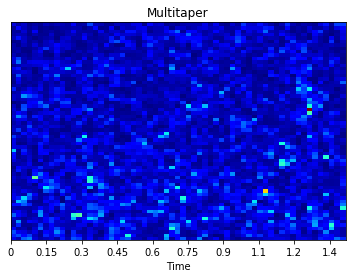

--- chunk nr 4810 recording BUK4_20171017_015504b run 68---  
[[1.40344725e-06 1.15213380e-06 9.41282529e-07 ... 7.11746952e-06
  3.46149739e-06 3.43522538e-06]
 [4.74600593e-06 4.37510226e-06 6.33446710e-06 ... 5.45187705e-06
  2.65219284e-06 2.73833191e-06]
 [2.50364237e-06 1.09567147e-06 3.01552947e-06 ... 1.44093548e-05
  6.64720541e-07 1.59569697e-06]
 ...
 [3.15298845e-06 1.95922240e-06 4.13234179e-06 ... 2.67507108e-06
  1.50413449e-06 1.93848278e-06]
 [2.27530624e-06 4.71088610e-06 8.69191645e-07 ... 1.41301557e-06
  1.70128763e-06 1.41533686e-06]
 [3.27840424e-06 7.23473673e-06 3.83763243e-06 ... 2.38866120e-06
  2.72632255e-06 4.36208445e-07]]


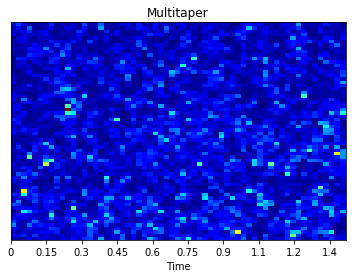

--- chunk nr 4863 recording BUK4_20171017_015504b run 69---  
[[5.02373517e-06 1.97594259e-06 5.56384830e-06 ... 4.19093259e-06
  3.55516744e-05 2.48403392e-06]
 [8.43672929e-06 1.50000213e-06 3.15873935e-06 ... 7.14890103e-06
  3.56370531e-06 1.20265487e-06]
 [3.63260206e-06 3.65789266e-06 8.87296728e-07 ... 7.49532063e-06
  8.42363329e-06 5.83173101e-06]
 ...
 [1.29597094e-06 3.57865653e-06 1.71188188e-06 ... 1.31230830e-04
  1.26326573e-04 7.81407016e-06]
 [1.99521751e-06 4.56120377e-06 9.63403341e-07 ... 3.06704862e-04
  3.76465425e-05 3.44243736e-06]
 [2.62335693e-06 3.40613132e-06 9.16455521e-06 ... 3.35875444e-04
  9.75435383e-05 2.02049505e-05]]


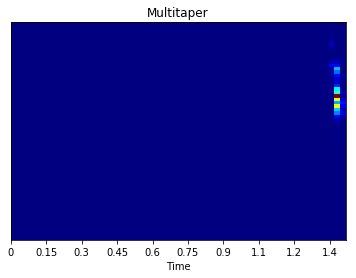

--- chunk nr 4864 recording BUK4_20171017_015504b run 70---  
[[7.10349405e-06 7.91822254e-06 1.22697569e-05 ... 3.67115866e-06
  1.20880939e-06 5.36630743e-06]
 [1.20229264e-05 1.49605094e-05 2.77593014e-06 ... 5.37330940e-06
  5.50311179e-06 2.63190637e-06]
 [3.77603388e-06 9.58548738e-06 0.00000000e+00 ... 1.64882034e-06
  9.12707027e-06 3.13724653e-06]
 ...
 [8.40036845e-07 1.86932989e-06 1.12626790e-06 ... 1.34880212e-06
  3.53042390e-06 9.83288705e-07]
 [1.48358405e-06 1.38847155e-06 3.44055916e-06 ... 1.59103385e-06
  1.70800626e-06 3.90811112e-06]
 [1.30686214e-06 5.85229678e-07 7.66710749e-07 ... 9.00847406e-07
  3.87315360e-06 2.19187166e-06]]


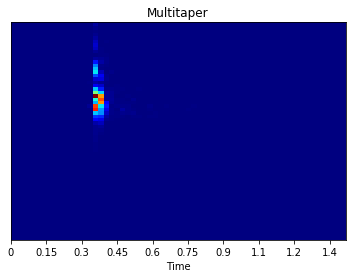

--- chunk nr 5034 recording BUK4_20171017_015504b run 71---  
[[8.13376049e-07 1.71417817e-06 5.27416134e-06 ... 1.32583373e-06
  9.32109288e-06 9.53548575e-07]
 [8.87076321e-06 4.73062385e-06 7.27571898e-06 ... 2.52543491e-06
  6.17073243e-06 7.75729386e-07]
 [1.20632522e-05 2.65159010e-06 2.70611367e-06 ... 1.90308330e-06
  9.04146068e-06 2.82125009e-06]
 ...
 [1.23044185e-06 5.49820526e-06 7.42279155e-08 ... 2.77899618e-06
  3.07429667e-06 1.97446483e-06]
 [1.37457273e-06 2.72063209e-06 5.08211465e-06 ... 1.72935407e-06
  1.82392995e-06 8.66402173e-06]
 [2.16444875e-06 2.78297011e-06 3.83865857e-06 ... 5.63088595e-06
  2.53425751e-06 3.58807104e-06]]


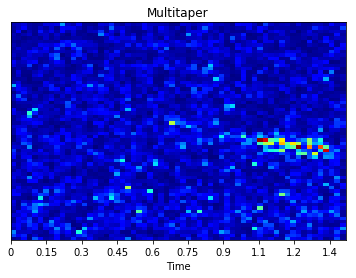

--- chunk nr 5035 recording BUK4_20171017_015504b run 72---  
[[1.65894132e-06 2.57314246e-06 1.43473108e-06 ... 6.22165922e-06
  6.28142842e-07 1.51916307e-06]
 [1.09901223e-06 3.76119844e-06 3.19860126e-06 ... 2.79091297e-06
  3.73001993e-06 2.95279144e-06]
 [3.68000502e-06 4.87716580e-06 4.61414274e-06 ... 1.54966918e-06
  1.69512677e-06 5.10326745e-06]
 ...
 [2.33994860e-06 4.53916957e-06 2.12118281e-06 ... 8.12731650e-07
  2.64007259e-06 6.68841310e-07]
 [5.43048298e-06 3.45314444e-06 7.93784950e-06 ... 1.37923181e-06
  1.93561350e-06 1.06234037e-06]
 [3.91252782e-06 1.21573836e-06 0.00000000e+00 ... 1.02834559e-06
  7.40489071e-07 5.54134157e-06]]


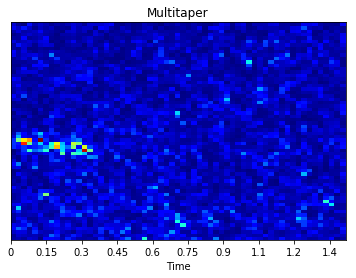

(64, 61)


In [119]:
myaudio = audiosegment.from_file(source_audio + name + ".wav")

duration_in_ms = len(myaudio) #Length of audio in ms
nr_of_chunks =  1 + (duration_in_ms - chunk_length_ms) / (chunk_length_ms - chunk_overlap)

hasbird_frame_no_dup = sorted(list(set(hasbird_frame)))
print(hasbird_frame_no_dup )
print(hasbird_frame)
run = 0
freqs, ind = libtfr.fgrid(fs, 512, fpass=(4000,9500)) 

for i in (hasbird_frame_no_dup): #range(129,133): #0,math.floor(nr_of_chunks)):
    hadbird = 0;
    frame_start = i*(chunk_length_ms - chunk_overlap)
    frame_end = i*(chunk_length_ms - chunk_overlap)+ chunk_length_ms
    frame = myaudio[frame_start : frame_end]

    samples = frame.get_array_of_samples()
    samples_float = librosa.util.buf_to_float(samples,n_bytes=2,dtype=np.float32)
    audio = np.array(samples_float)


    #result5 = libtfr.tfr_spec(samples_float, N = 512, step = 30, Np = 512, K =6, tm =6, flock =0.1, tlock = 5)
    #plt.imshow(S, cmap="jet")
    #result5 = libtfr.tfr_spec(audio, N = 512, step = 355, Np = 512, K = 2, tm = 1, flock =0.1, tlock = 10) takie w result5
    result5 = libtfr.tfr_spec(audio, N = 512, step = 355, Np = 512, K = 3, tm = 1, flock =0.1, tlock = 10)     

    result5 = result5[ind,]; # tylko interesujące nas pasmo

    if(np.isinf(result5).any()):
      print("inf: " + str(i))
    if(np.isnan(result5).any()):
      print("nan: " + str(i))
    
    
    run = run+1
    if (run%1==0): # 500
      print("--- chunk nr %s recording %s run %s---  " % (i, name, run))
      print(result5)
      plt.title('Multitaper')
      librosa.display.specshow(result5,cmap="jet", x_axis='time')
      #librosa.display.specshow(result5[40:90],x_axis='time')
      #plt.imshow(result5, cmap="jet")
      #plt.figure(figsize=(5, 5))
      plt.show()
      #print(np.isinf(result5).any()) 
      #print(np.isnan(result5).any())

          
print(np.shape(result5))      